In [60]:
import wrangle as w

import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
import numpy as np

from scipy import stats

# Data Analysis (EDA)

Plan:

*- For estimates on metric averages, like average profit or sales, median will be used to reduce effects of outliers*

**1. Univariate Analysis** for summary of transactions and items sold

**2. Optimal Discount Rates:** Determine the optimal discount rates for business metrics.

&nbsp;&nbsp;&nbsp;**Bivariate Analysis:** Discount vs. Profit/Sales/Margin
<br>&nbsp;&nbsp;&nbsp;Group by discount and analyze sales, profit, margin, and quantity

- How do different discount rates impact sales?
- Is there a specific discount percentage that leads to the highest profit margins?
- Do higher discounts lead to a significant decrease in profitability due to increased costs or reduced margins?
- Do customers tend to buy more items when discounts are applied?

&nbsp;&nbsp;&nbsp;**Multivariate Analysis:** Discount vs. Profit/Sales/Margin on low, medium, and high-priced items
<br>&nbsp;&nbsp;&nbsp;Group items into certain price ranges and analyze the questions above again

- Stats test important insights

**4. Customer Impact:** Analyze customer response to discounts.

&nbsp;&nbsp;&nbsp;Do returning customers see more discounted orders than non-returning customers?

&nbsp;&nbsp;&nbsp;Are discounts and customer return dependent of each other?
- perform $\chi^2$ test to see if there is a dependent relationship between customer return and discounts.

Acquire and prepare data

In [2]:
df = w.prep_store_data()

In [73]:
df.head(3)

,order_id,order_date,ship_date,ship_mode,segment,city,state,postal_code,sales,quantity,discount,profit,customer_name,category,sub_category,region_name,product_name,order_month,order_year,cost,margin,discount_bin,price,price_bin
0,CA-2016-152156,2016-11-08,2016-11-11,Second Class,Consumer,Henderson,Kentucky,42420,261.96,2,0.0,41.9136,Claire Gute,Furniture,Bookcases,South,Bush Somerset Collection Bookcase,11,2016,220.0464,0.16,0,261.96,expensive
1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,Consumer,Henderson,Kentucky,42420,731.94,3,0.0,219.5820,Claire Gute,Furniture,Chairs,South,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",11,2016,512.3580,0.30,0,731.94,very-expensive
2,CA-2016-138688,2016-06-12,2016-06-16,Second Class,Corporate,Los Angeles,California,90036,14.62,2,0.0,6.8714,Darrin Van Huff,Office Supplies,Labels,West,Self-Adhesive Address Labels for Typewriters b...,6,2016,7.7486,0.47,0,14.62,cheap


---
## 1. Univariate Analysis

Categorical counts and frequencies:

SHIP_MODE


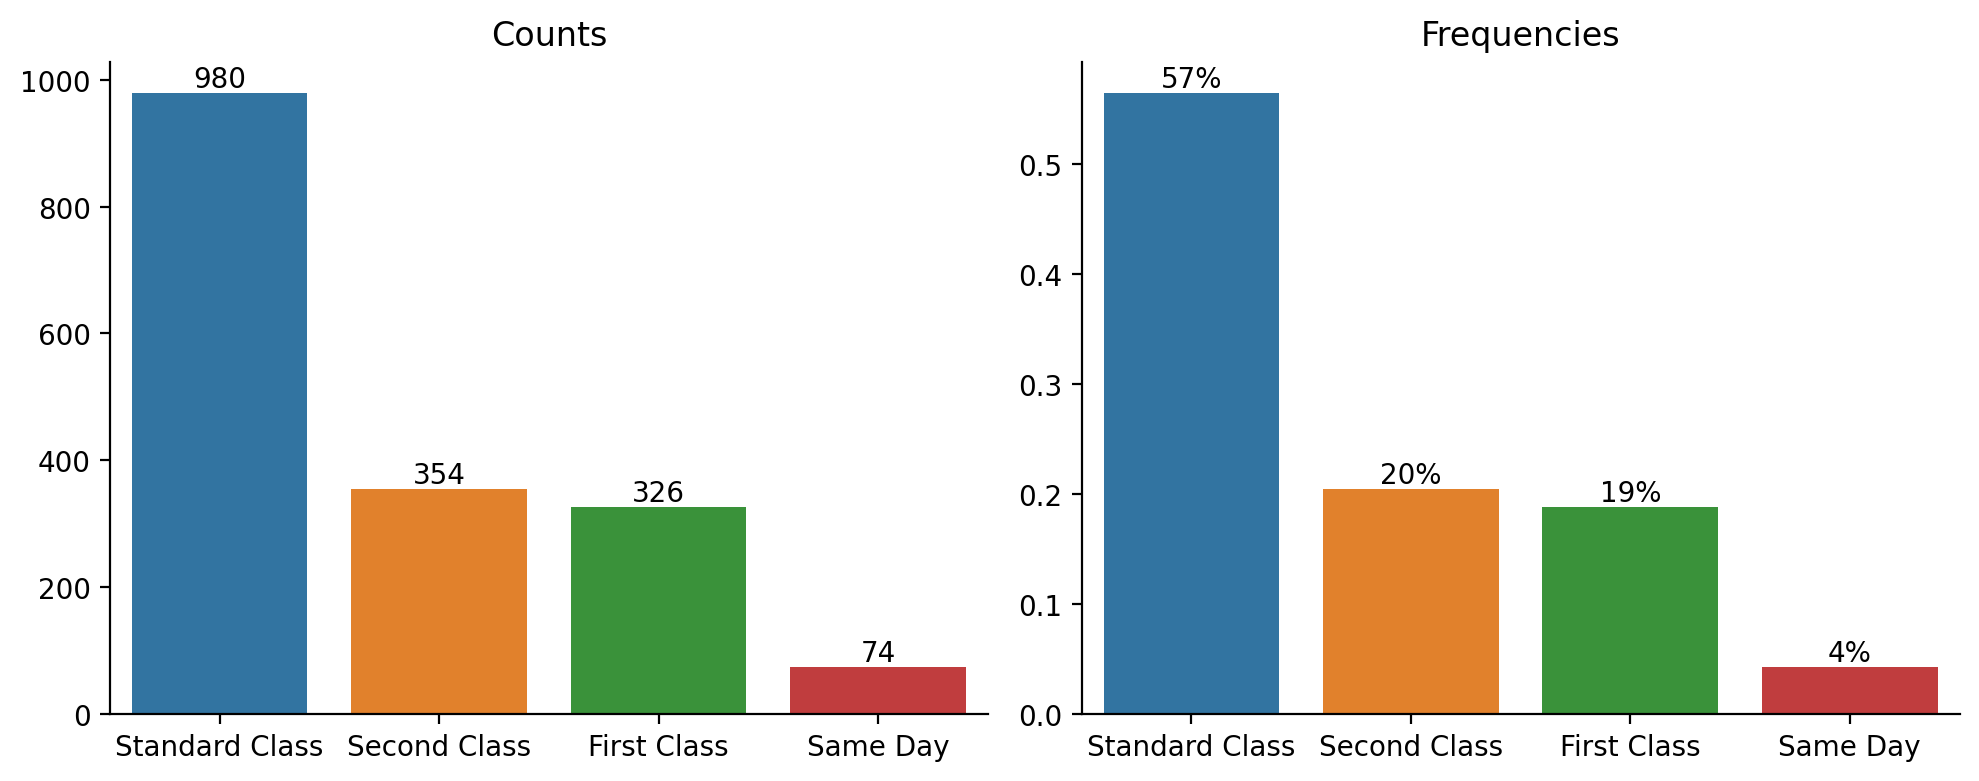

SEGMENT


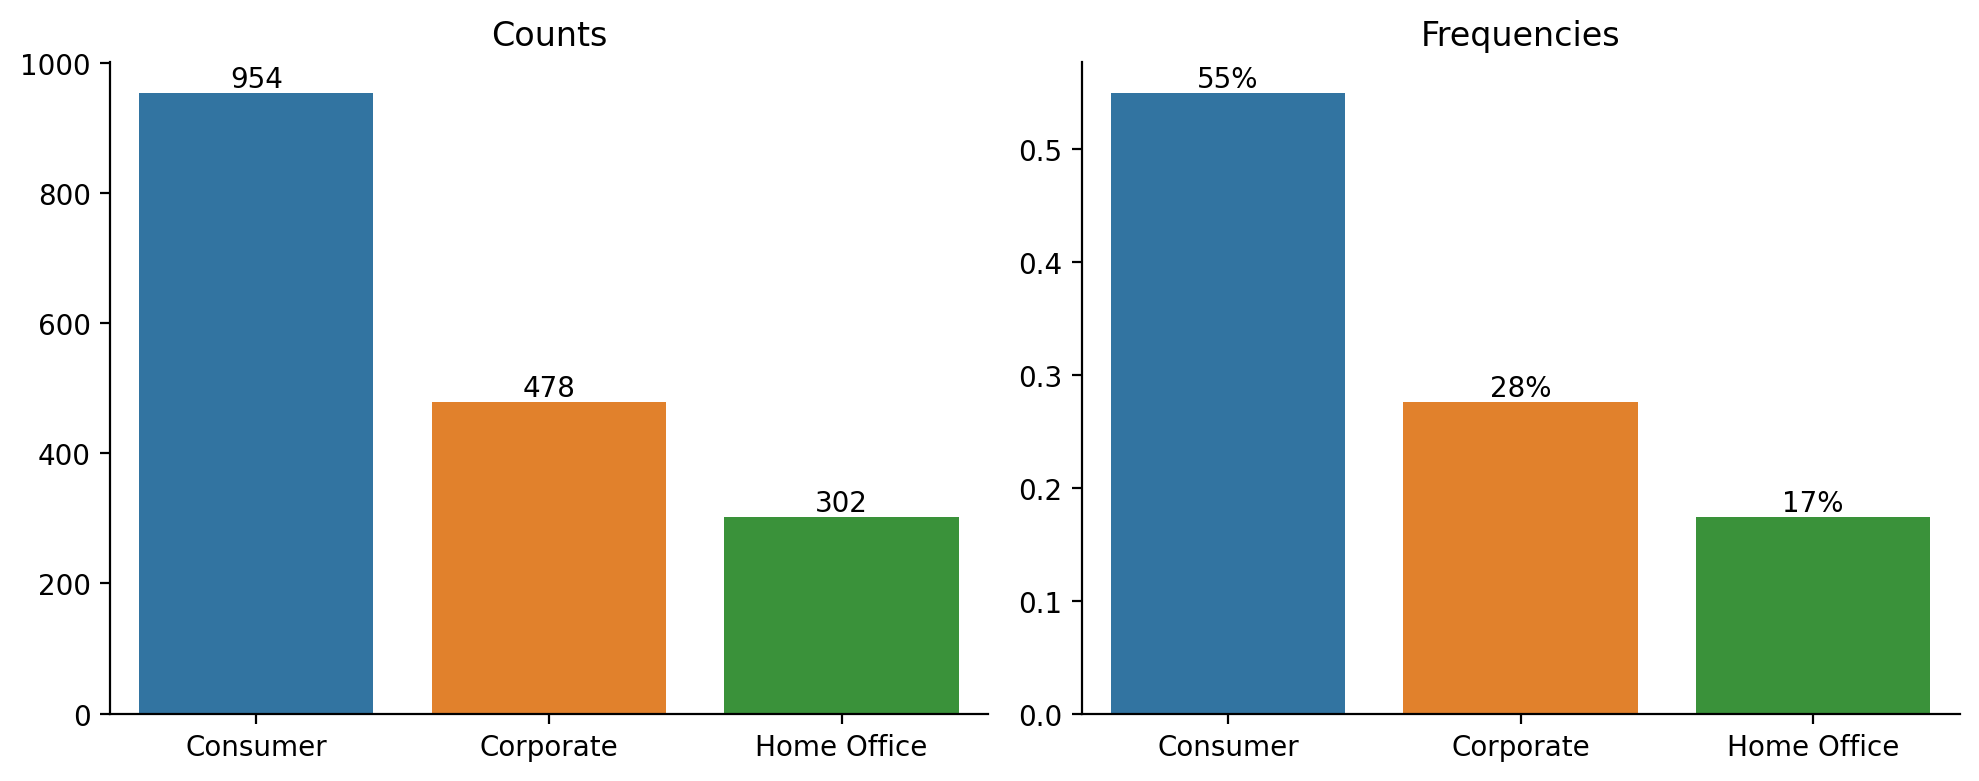

QUANTITY


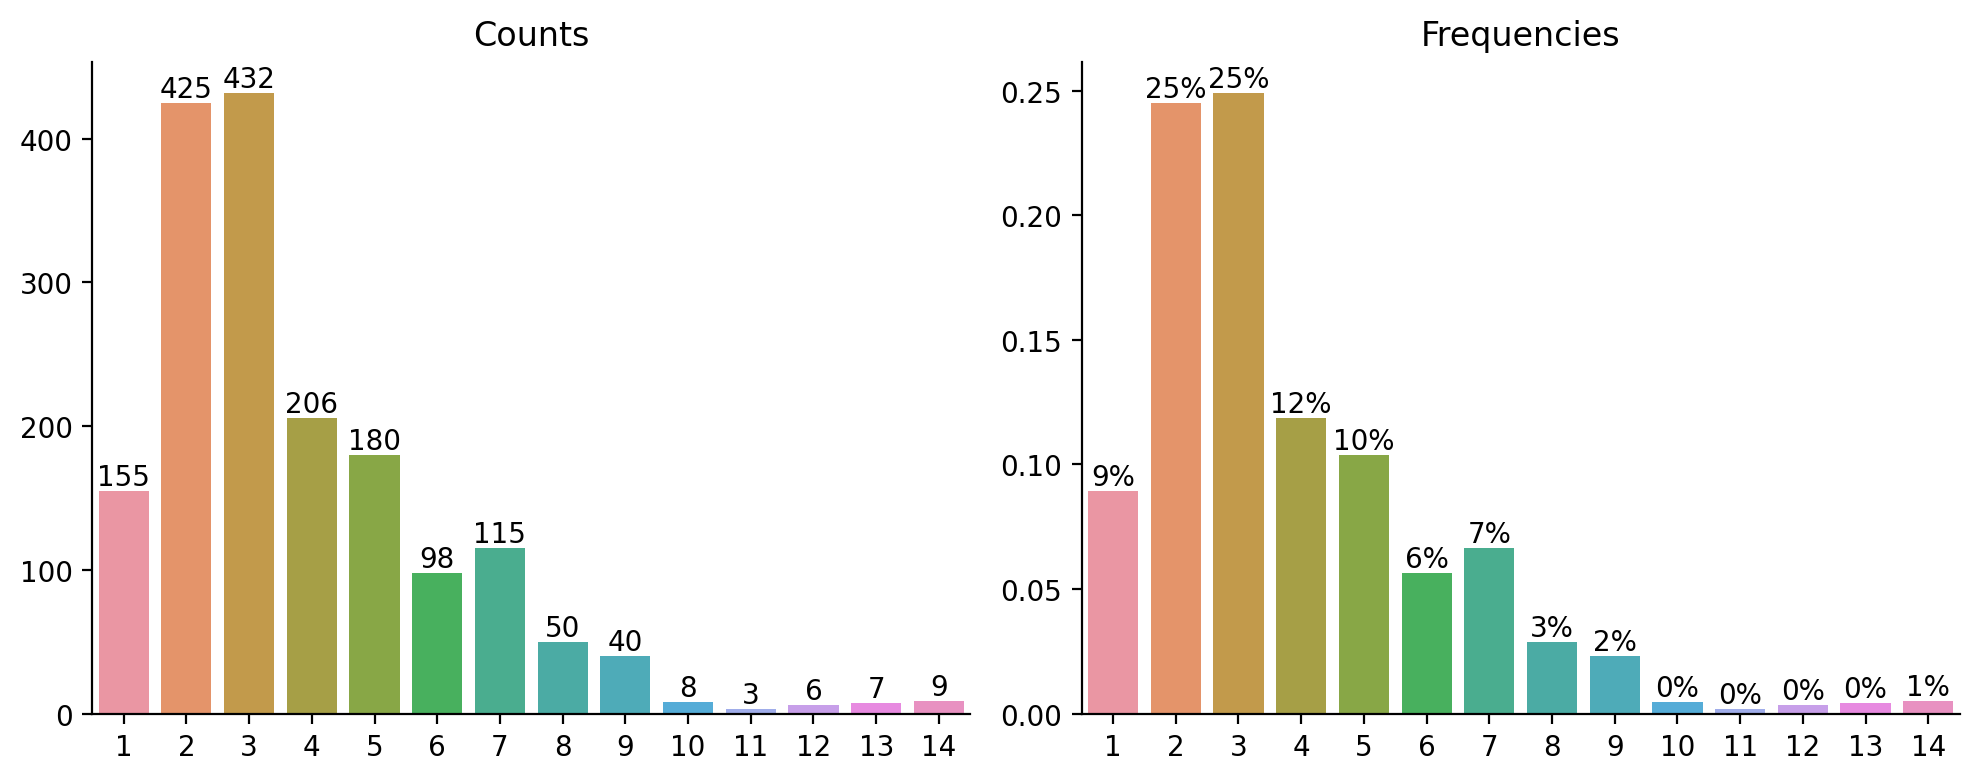

DISCOUNT


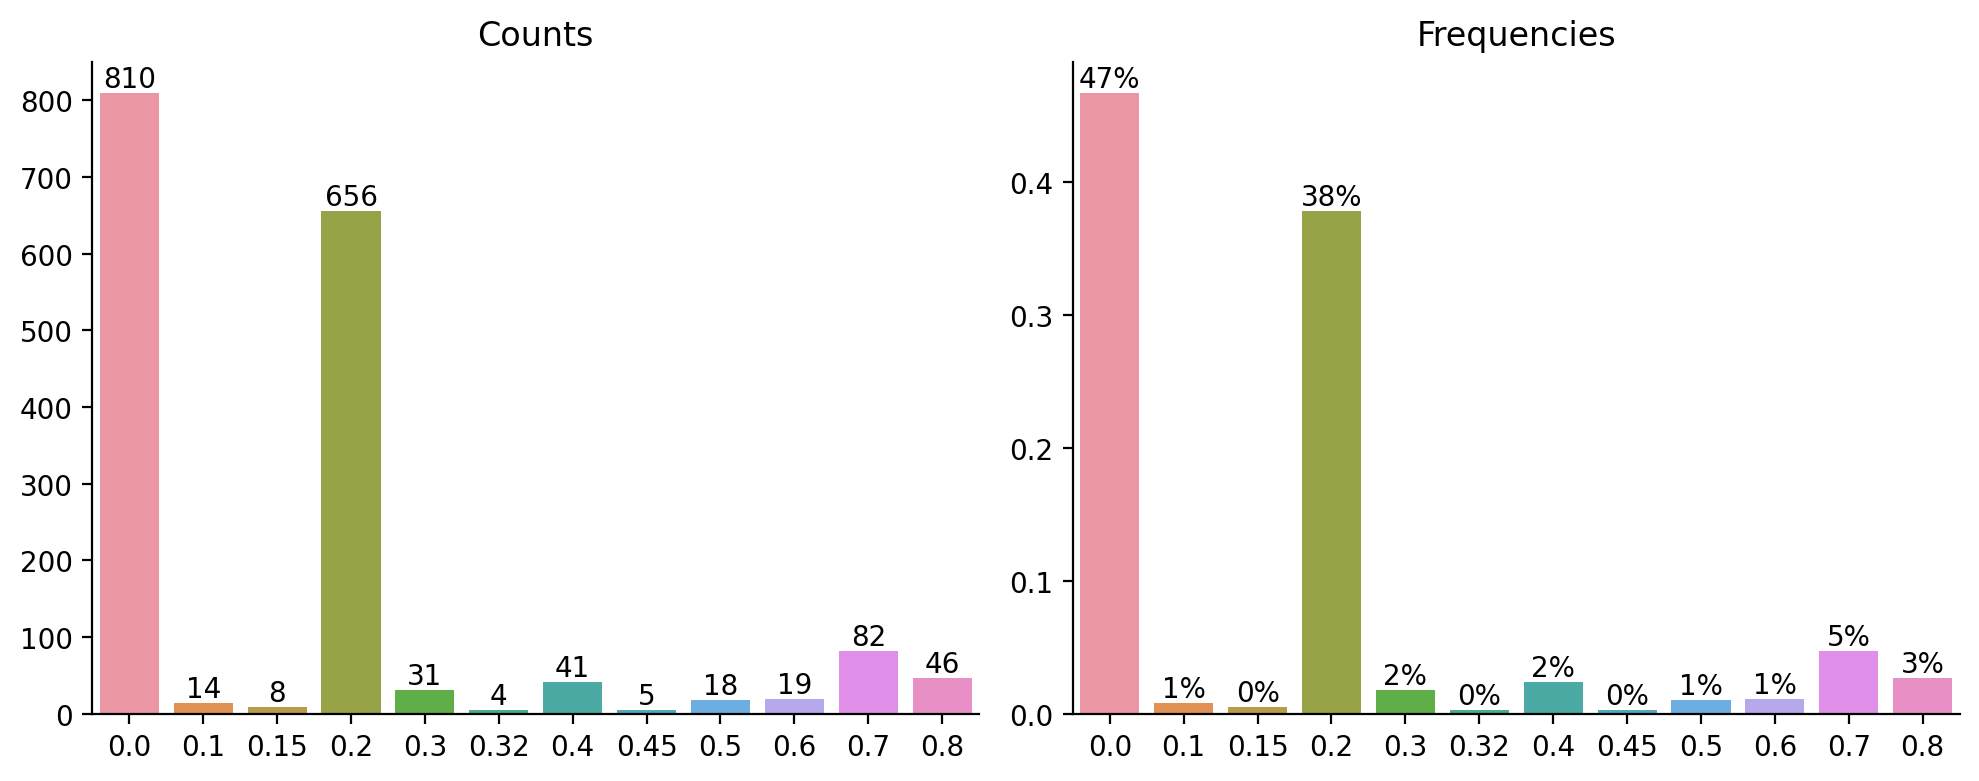

CATEGORY


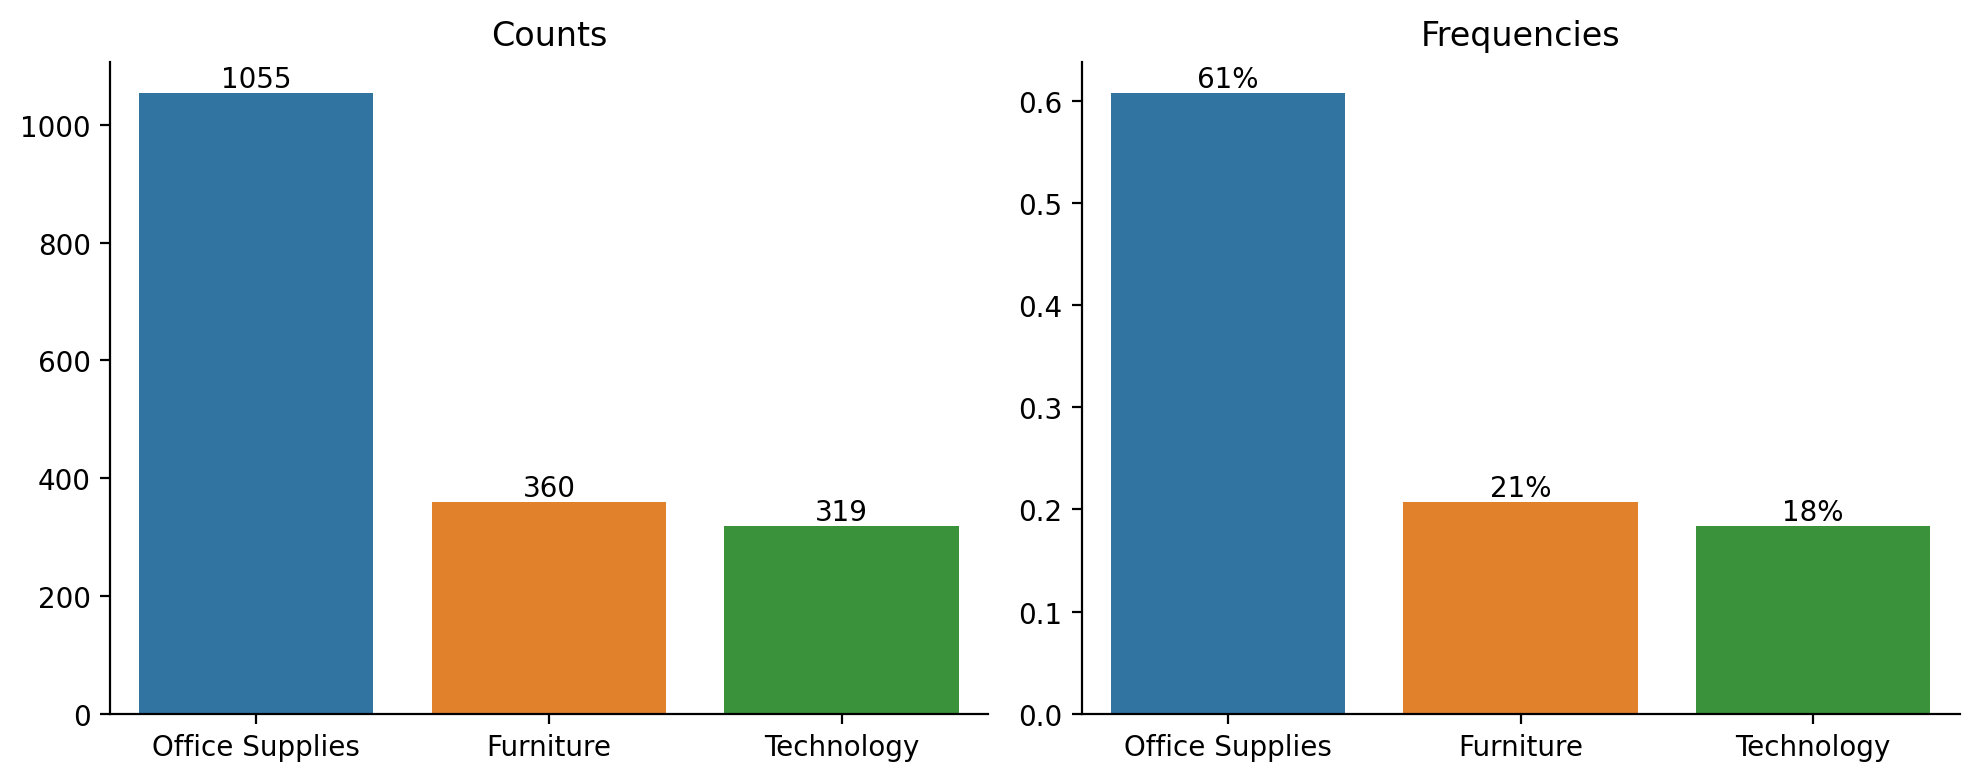

SUB_CATEGORY


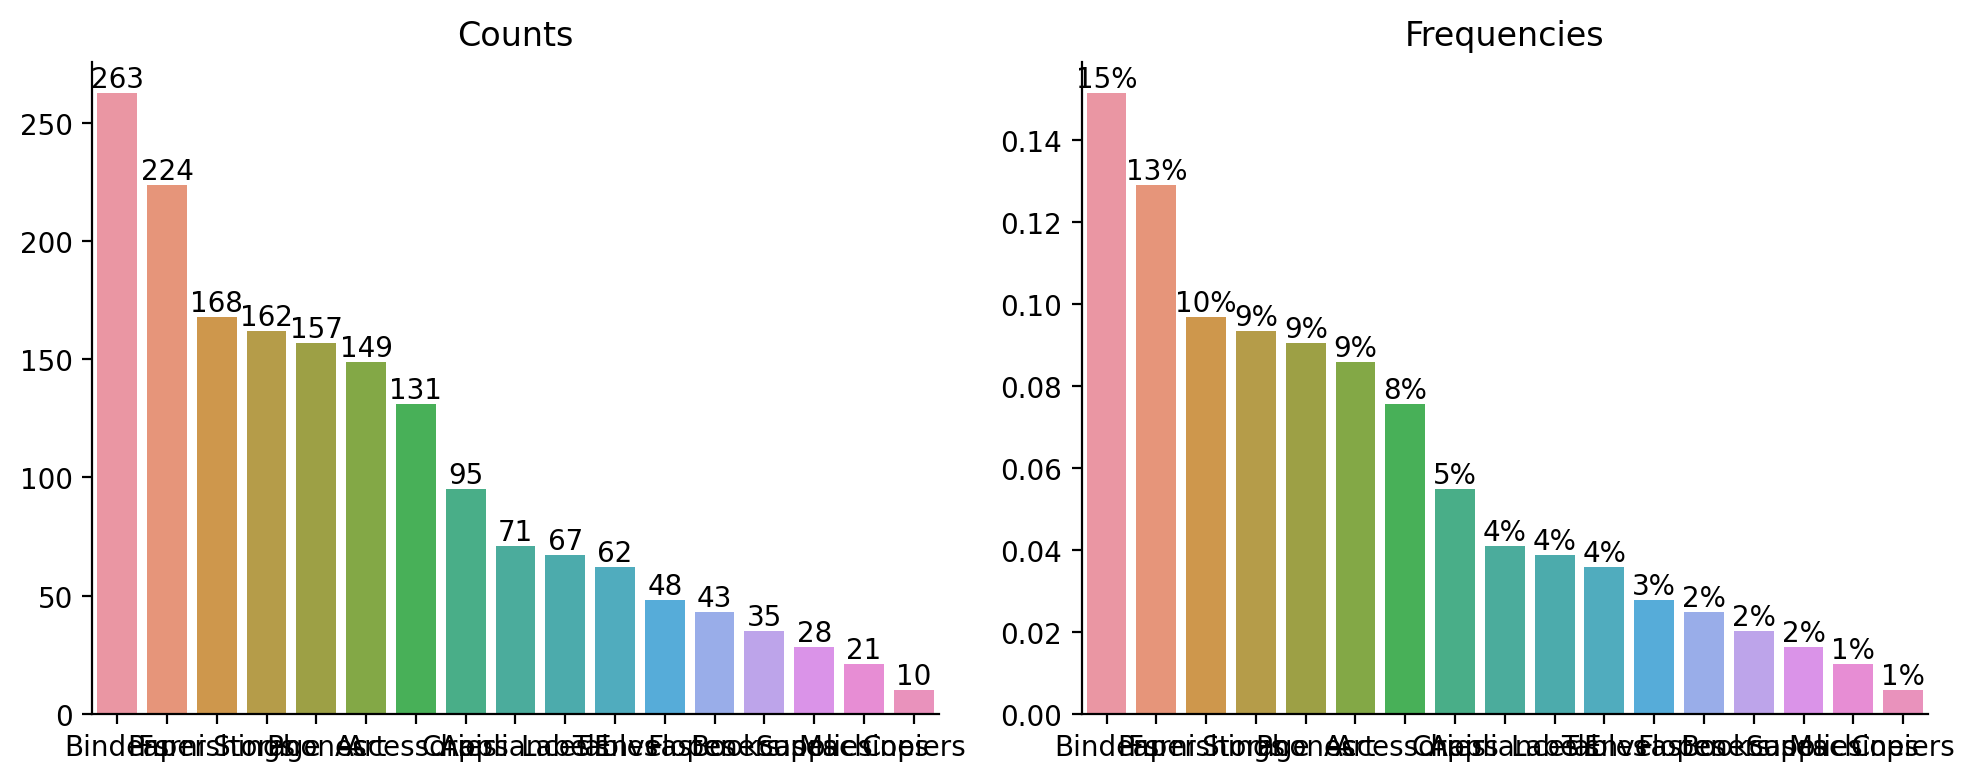

REGION_NAME


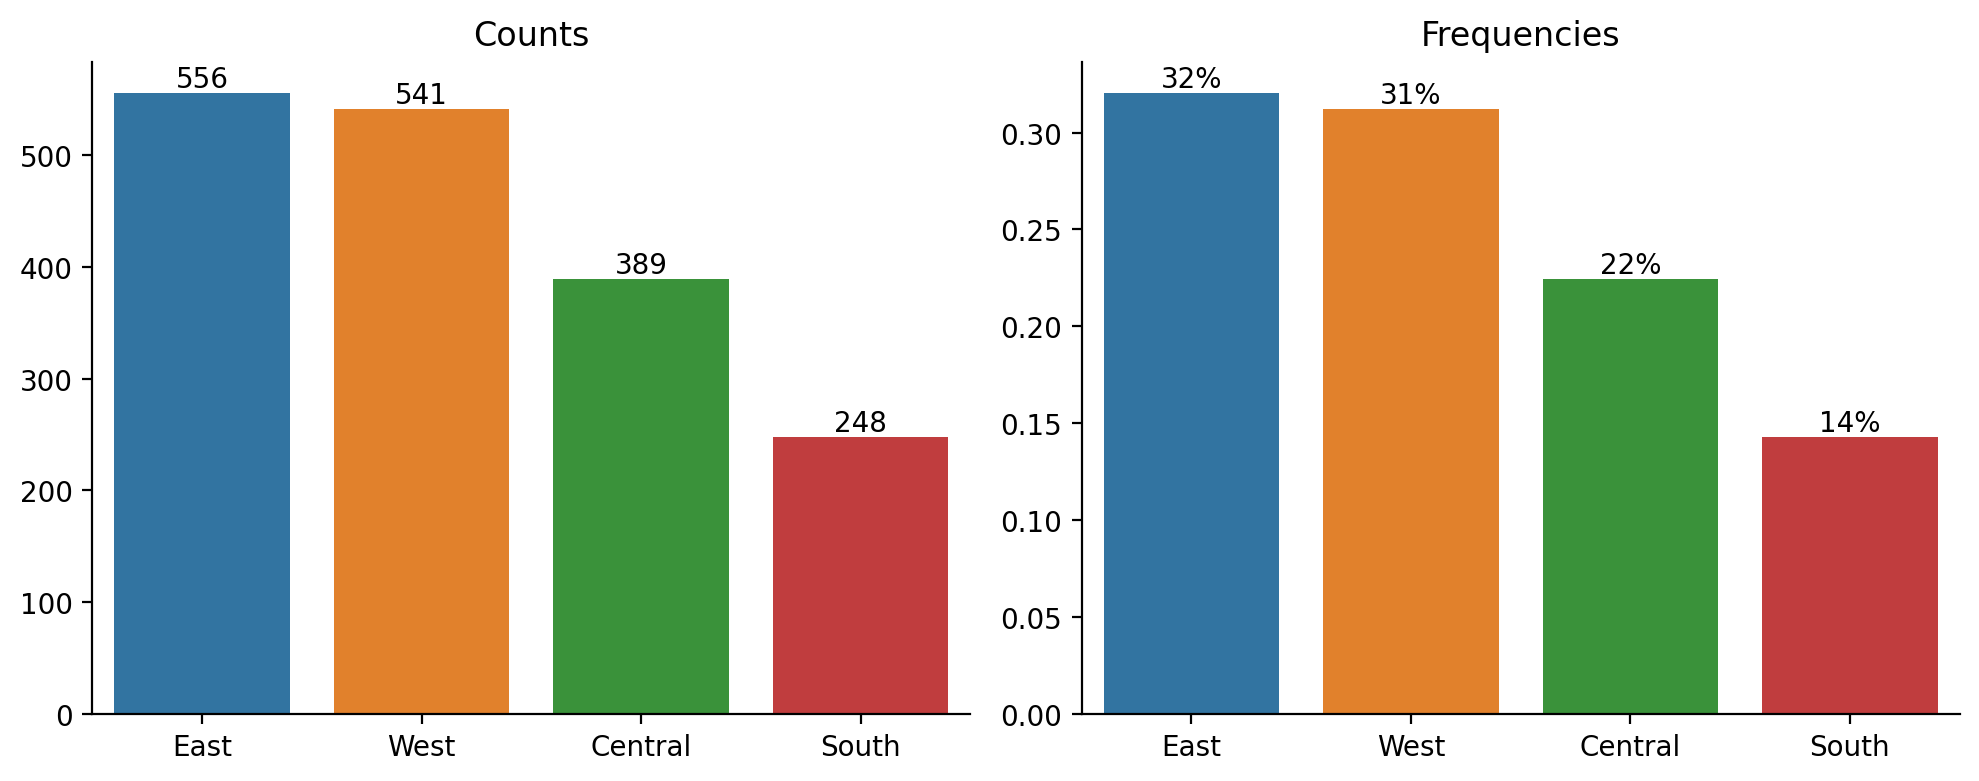

ORDER_MONTH


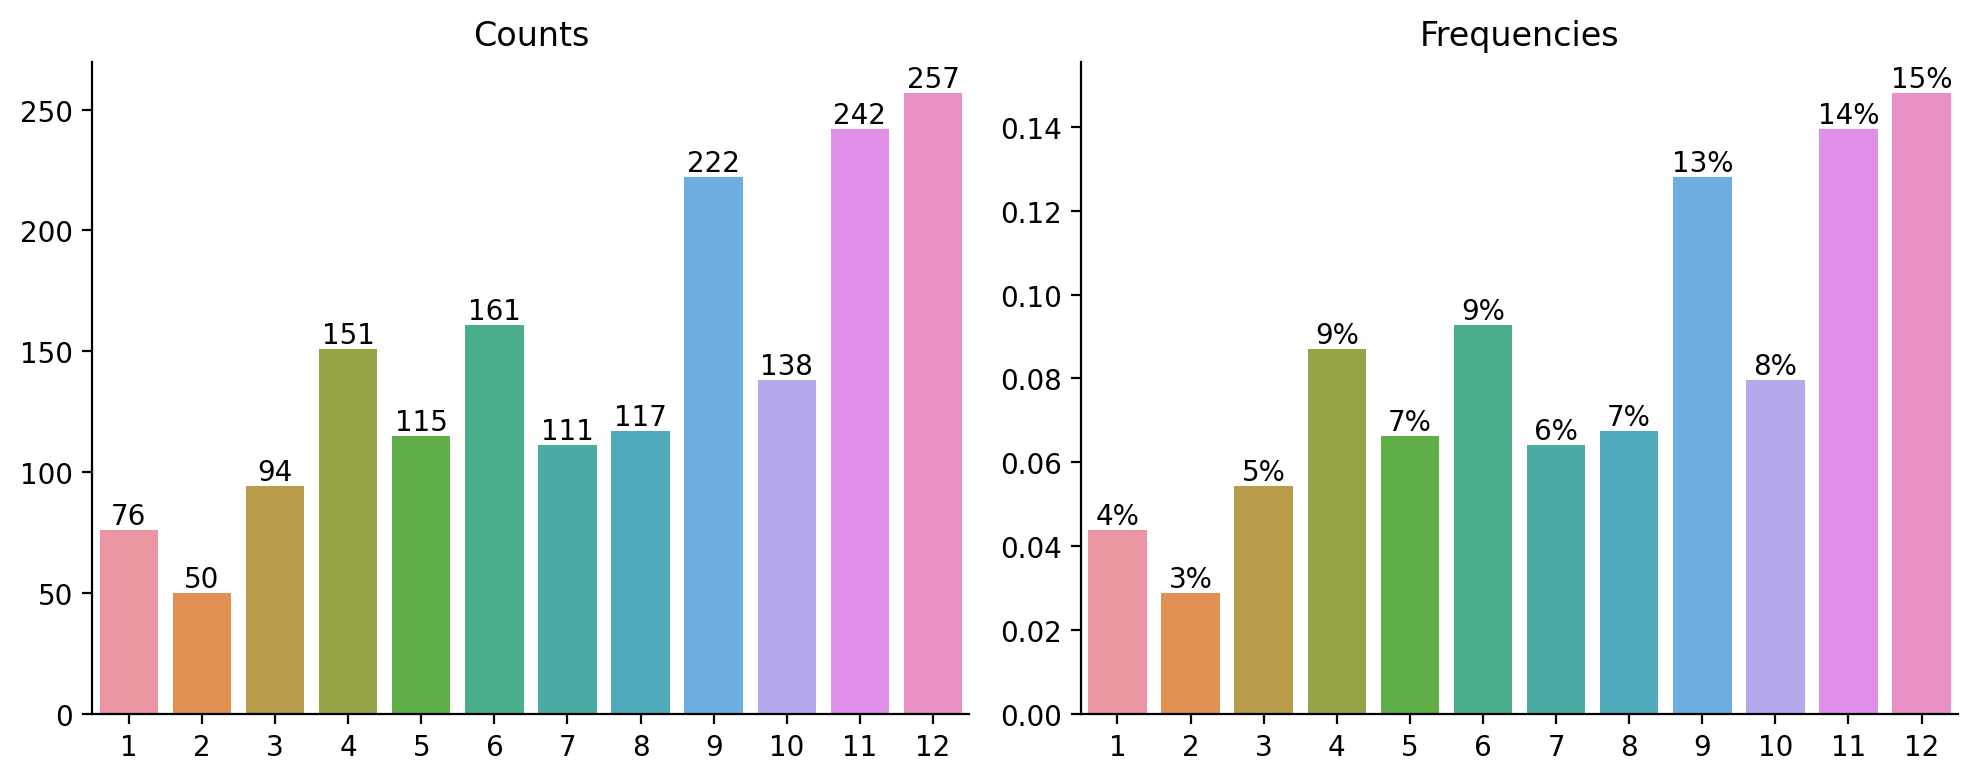

ORDER_YEAR


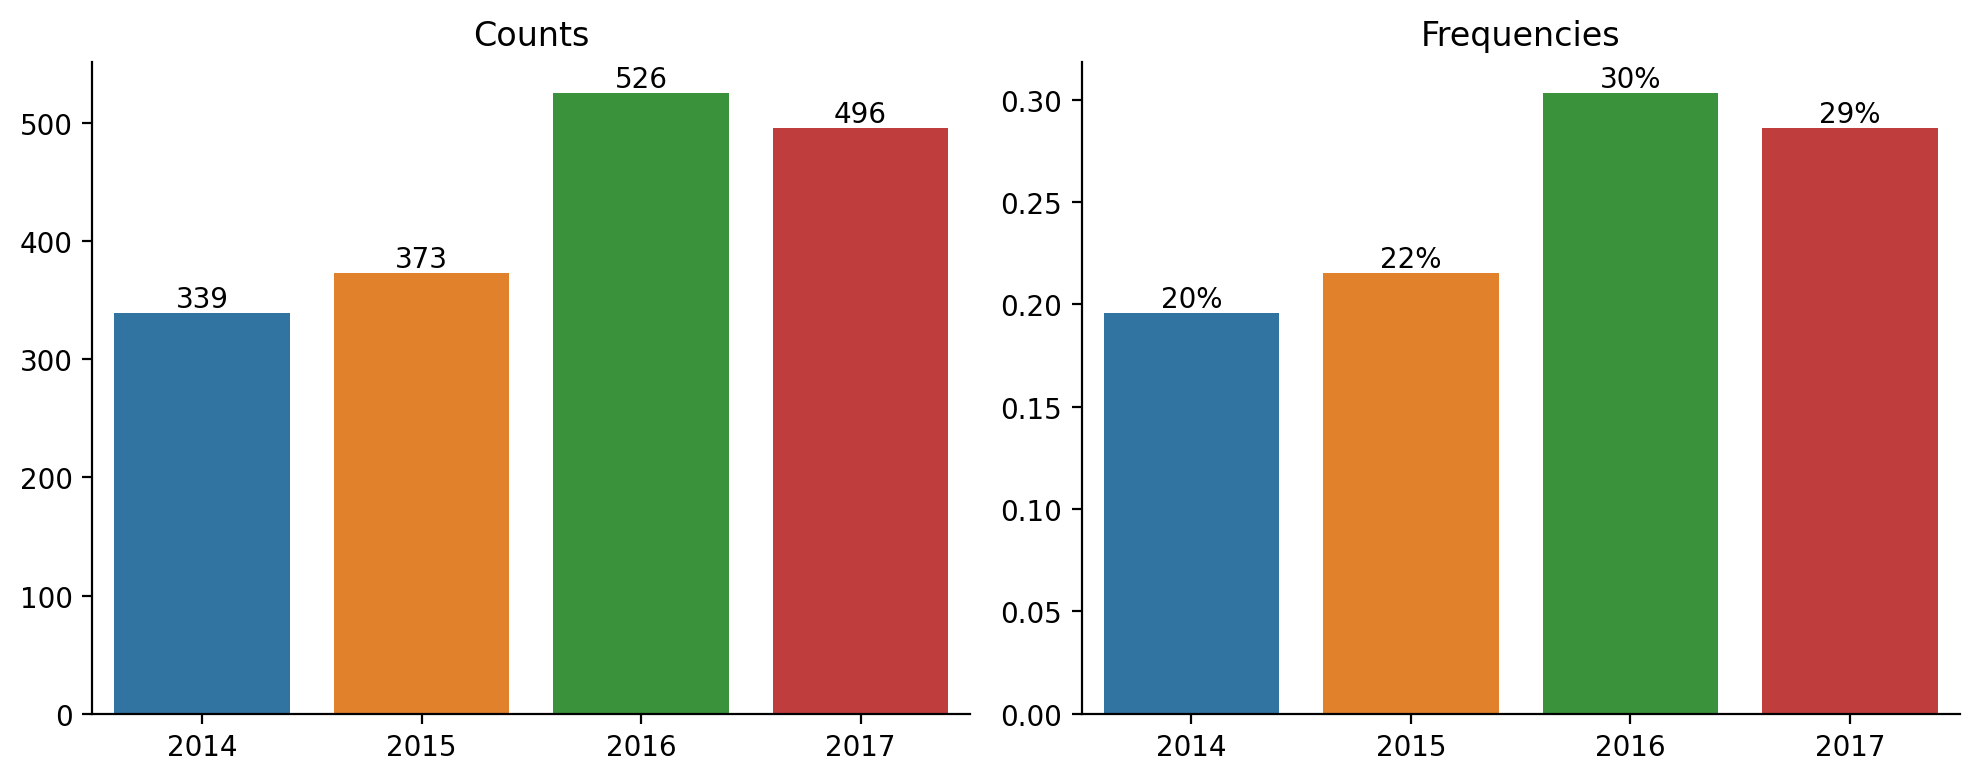

DISCOUNT_BIN


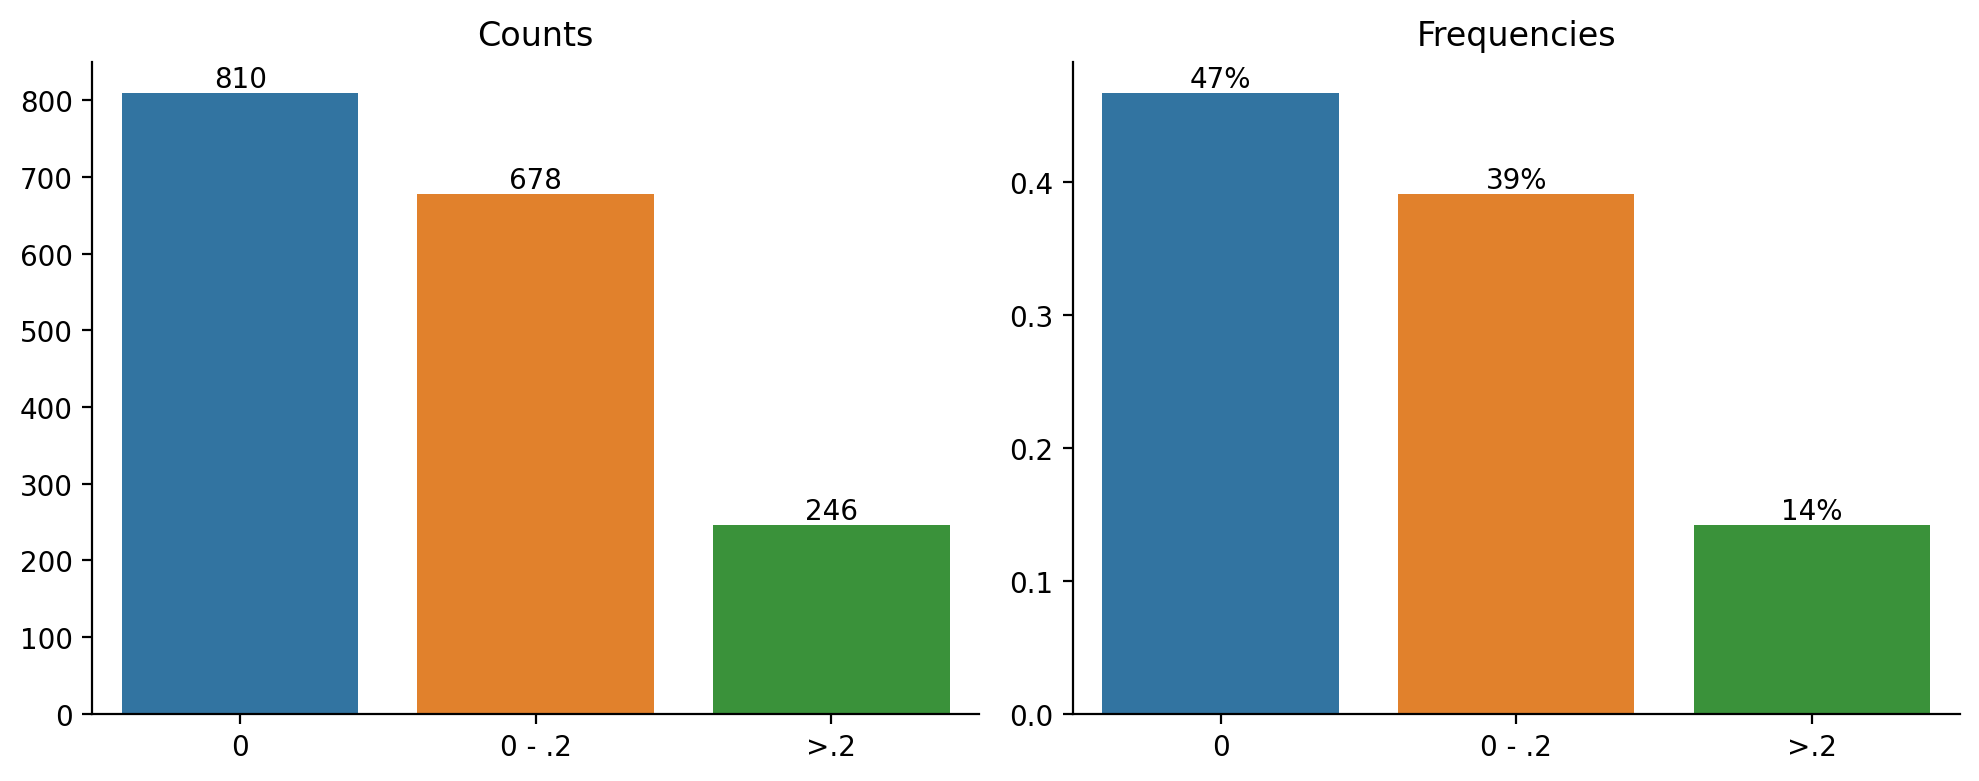

PRICE_BIN


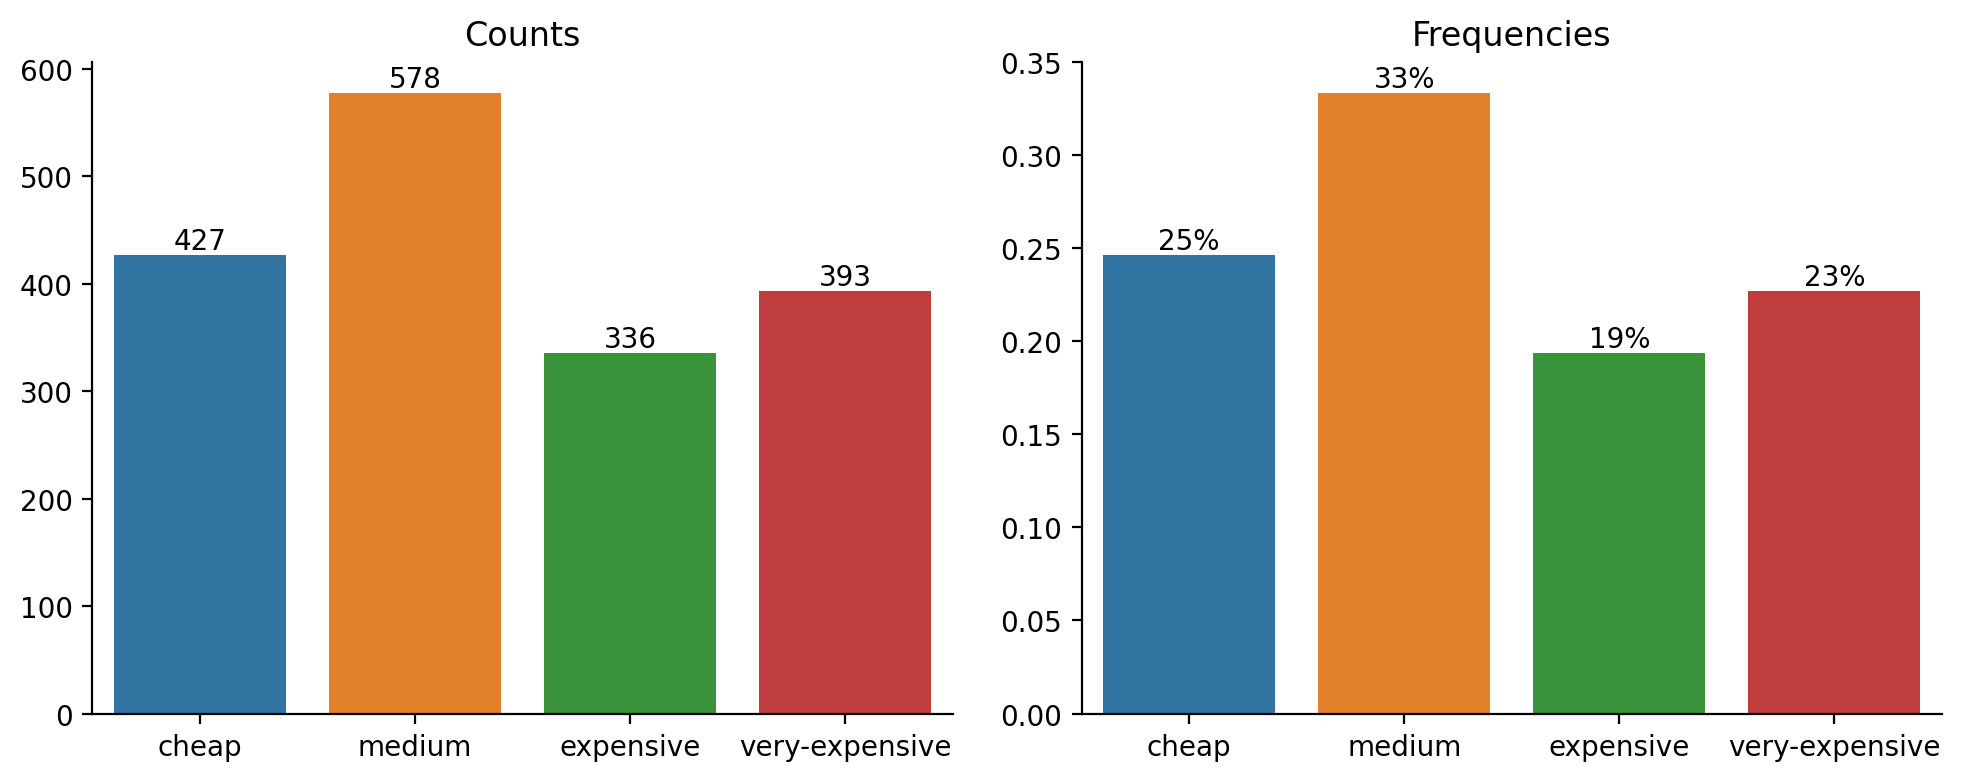

In [72]:
for col in df.columns:
    if df[col].nunique() < 20 or\
        (not pd.api.types.is_numeric_dtype(df[col]) and df[col].nunique() < 10):
        print(col.upper())
        # Calculate raw counts and normalized counts
        counts = df[col].value_counts()
        frequencies = counts / counts.sum()

        # Create a figure with two subplots
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        # Plot raw countplot in the first subplot
        sns.barplot(x=counts.index, y=counts.values, ax=axes[0])
        axes[0].set_title('Counts')

        # Plot normalized countplot in the second subplot
        sns.barplot(x=frequencies.index, y=frequencies.values, ax=axes[1])
        axes[1].set_title('Frequencies')

        # Add annotations to the bars in the normalized countplot
        for i, ax in enumerate(axes):
            for p in ax.patches:
                annotation = f'{p.get_height():.0f}' if i == 0\
                                                 else f'{p.get_height() * 100:.0f}%'
                ax.annotate(annotation, (p.get_x() + p.get_width() / 2, p.get_height()),
                            ha='center', va='bottom')


        # Adjust layout and display the plots
        plt.tight_layout()
        sns.despine()
        plt.show()

Important or interesting notes:
- 43% of ship modes are non-standard (some level of "premium")
- Half of sales are items bought in quantities of 2 or 3
- 47% of items have no discount, 38% have a 20% discount, and the rest have discounts of "random" values
- 61% of items are office supplies
- 28% of items are either binders or papers
- Later months have more items sold then early months
- 2014 to 2016 saw an increase in items sold, 2017 saw a slight dip

Numerical stats for continuous features and target:

,sales,profit,cost,margin,price
count,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000
mean,229.206358,21.880351,207.326007,0.120964,293.114798
std,532.862614,202.891949,537.409173,0.453685,767.823056
min,1.080000,-3839.990400,0.840000,-2.750000,1.680000
25%,16.695000,1.702400,11.682900,0.064375,20.422500
50%,52.245000,8.073050,42.957000,0.270000,65.065000
75%,209.917500,27.414450,187.184400,0.362500,253.480000
max,8159.952000,3177.475000,11839.970400,0.500000,15999.960000


<Figure size 600x200 with 0 Axes>

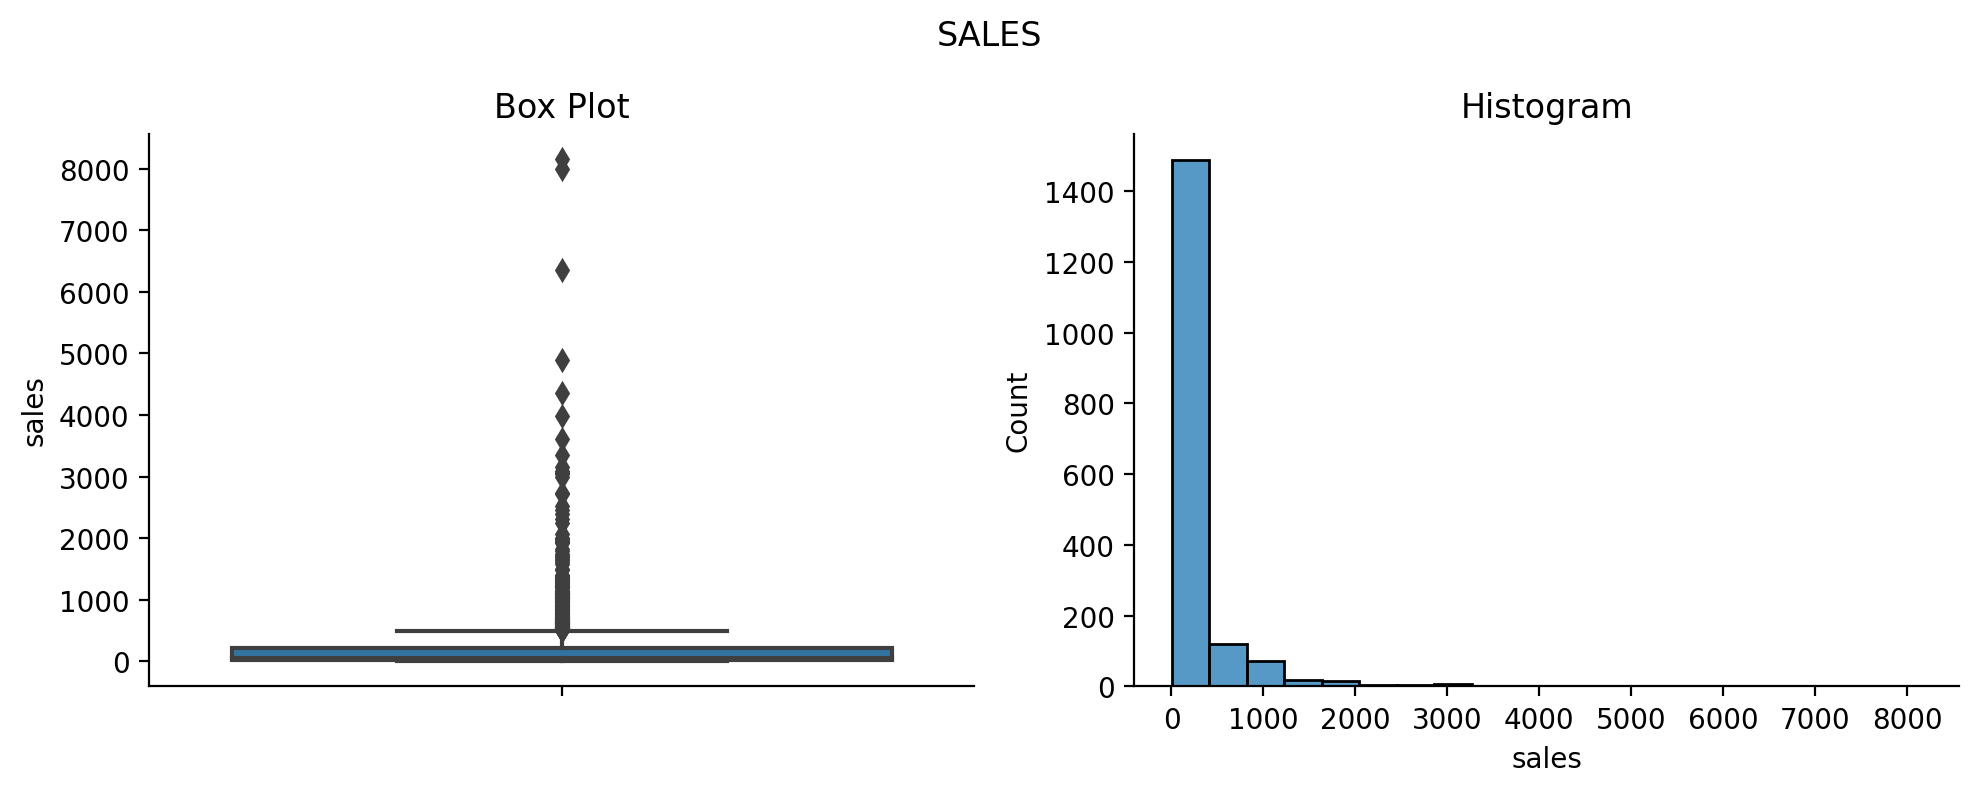

<Figure size 600x200 with 0 Axes>

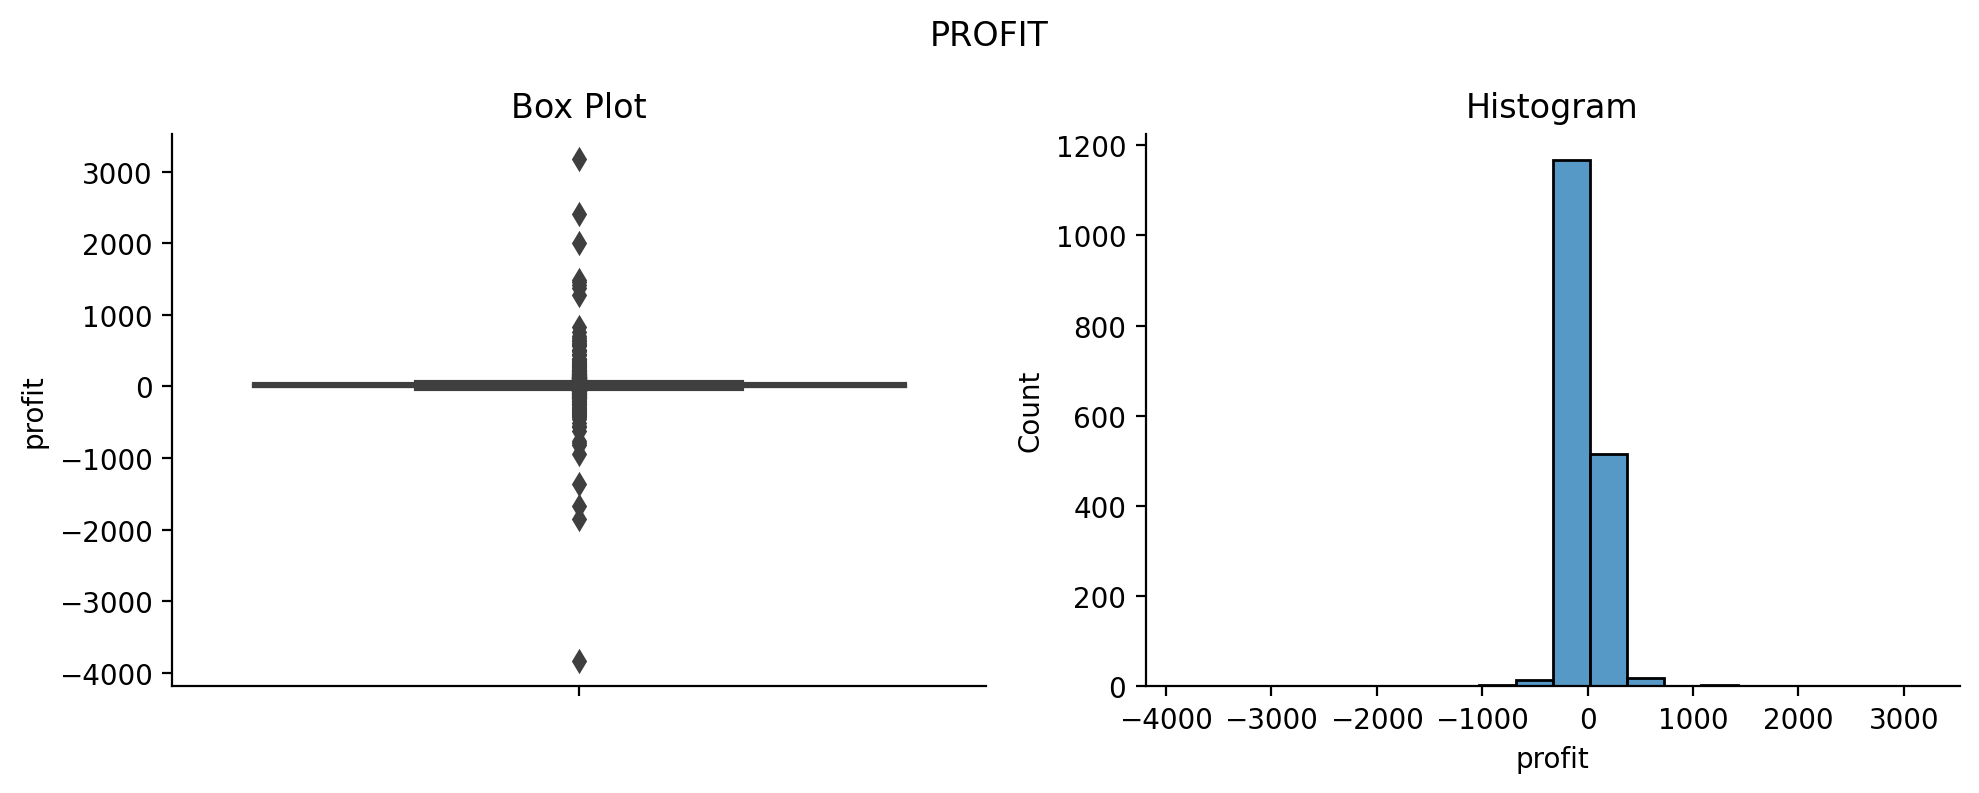

<Figure size 600x200 with 0 Axes>

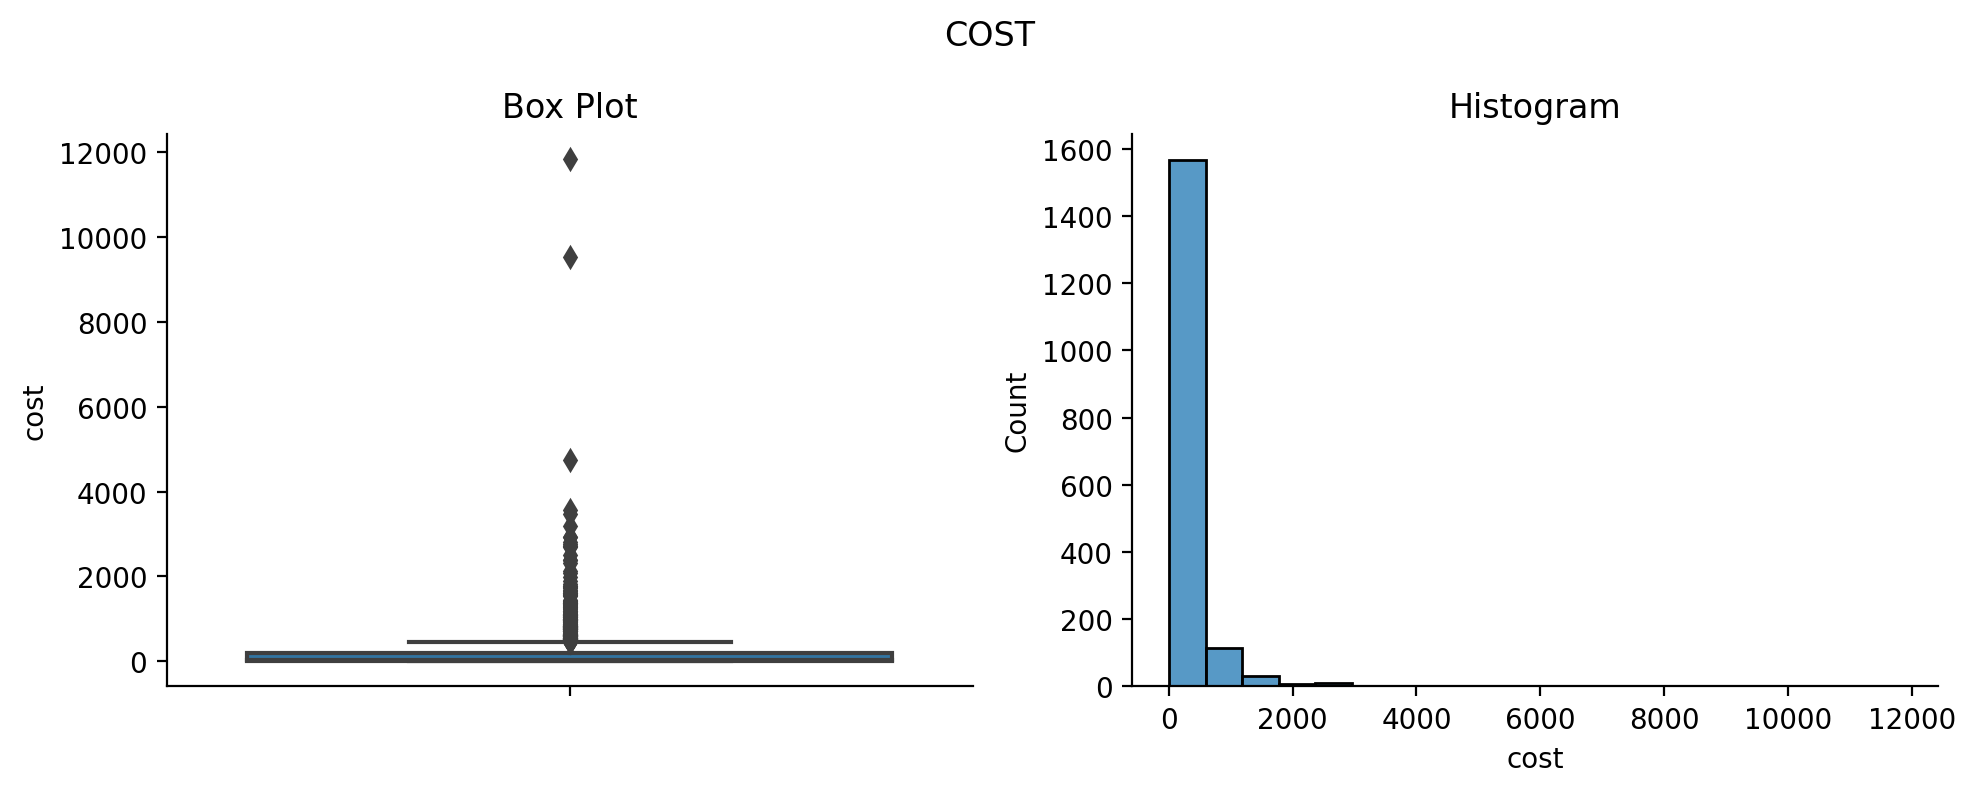

<Figure size 600x200 with 0 Axes>

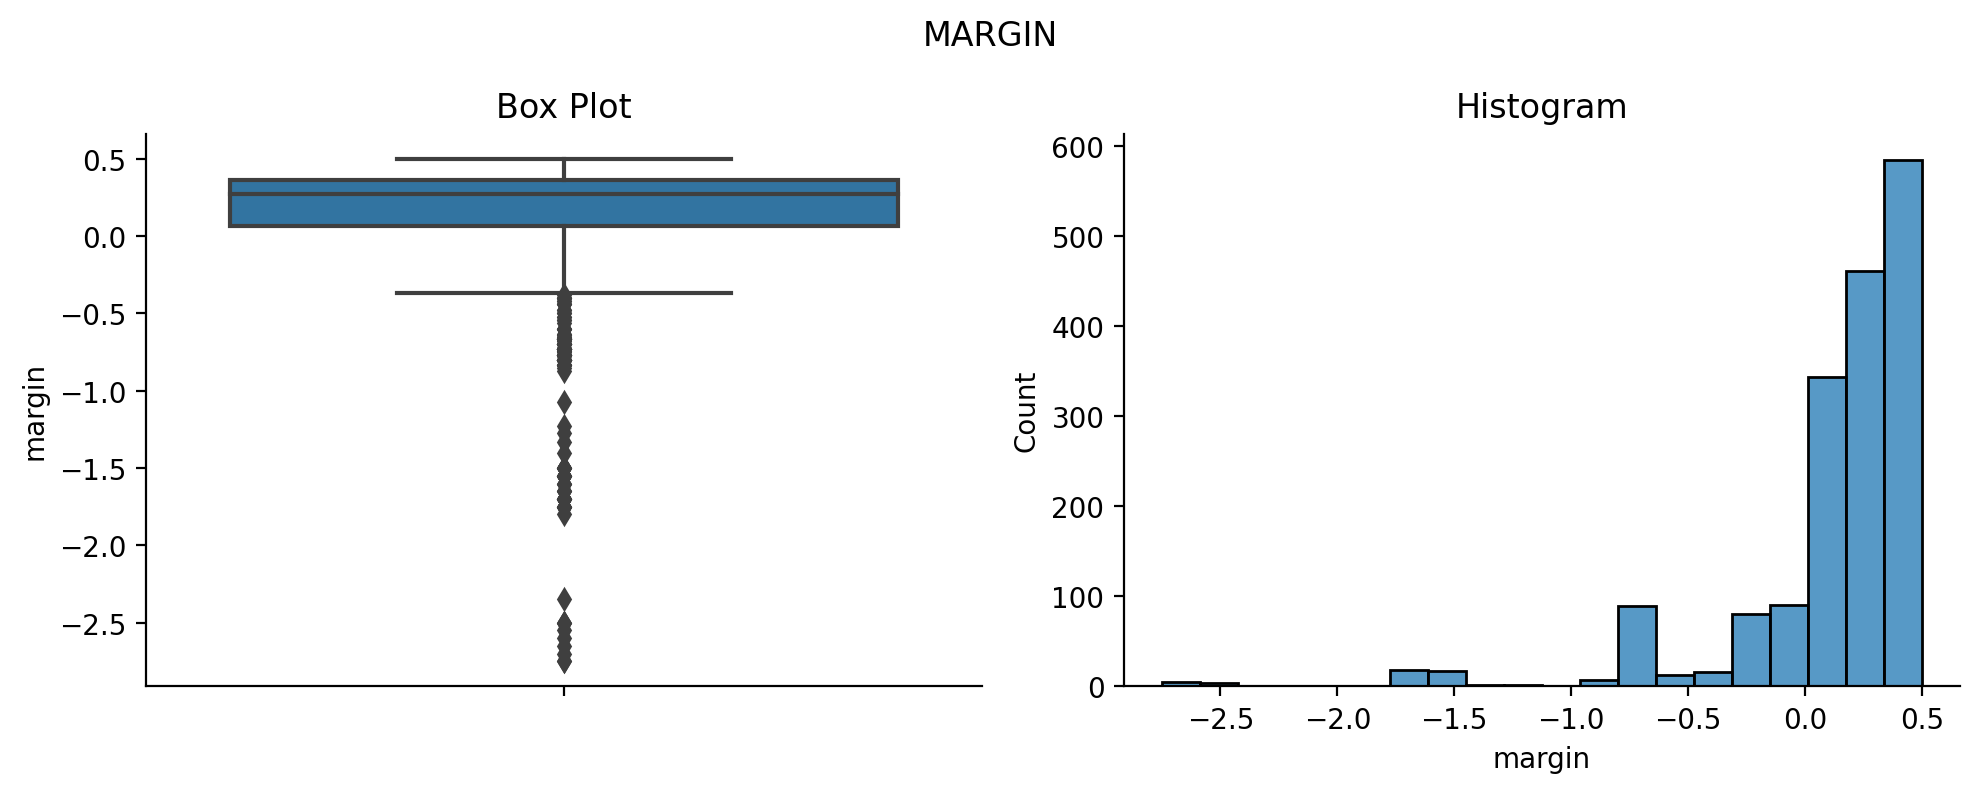

<Figure size 600x200 with 0 Axes>

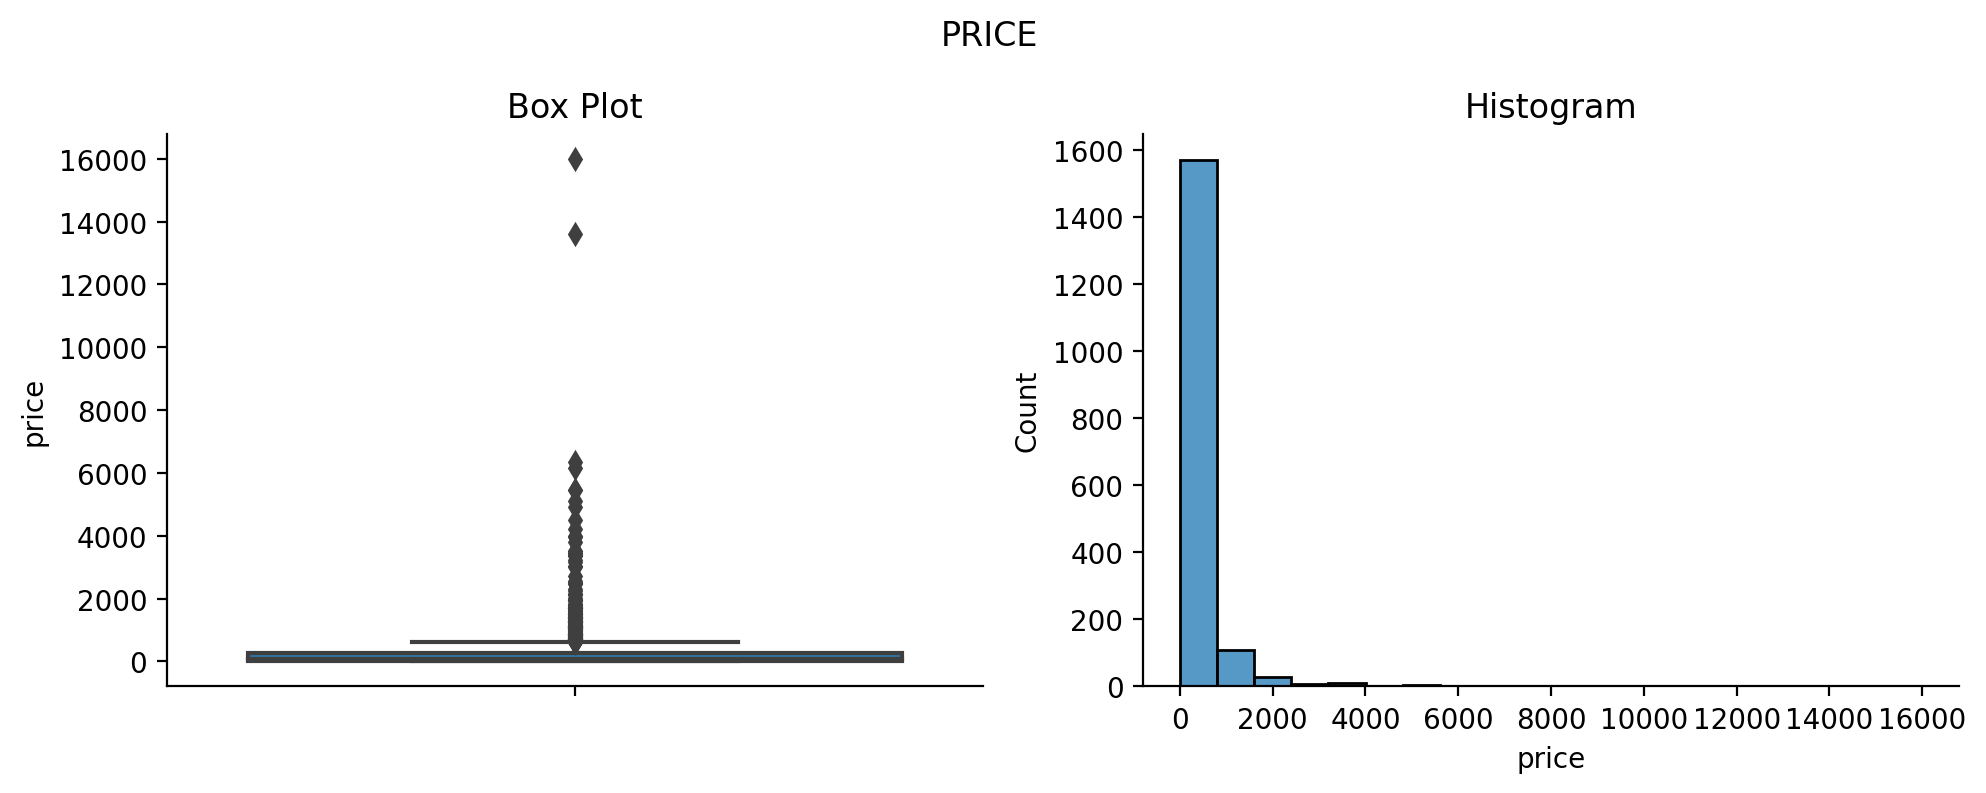

In [6]:
numeric_df = df.select_dtypes(include=['number'])\
                .loc[:, (df.nunique() >= 20) & (df.columns != 'postal_code')]

display(numeric_df.describe())

for col in df.columns:
    # skip postal_code column
    if col == 'postal_code': continue

    if pd.api.types.is_numeric_dtype(df[col]) and df[col].nunique() > 20:
        plt.figure(figsize=(6, 2))
        
        # Create a figure with two subplots
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        
        # Plot box plot in the first subplot
        sns.boxplot(data=df, y=col, ax=axes[0])
        axes[0].set_title('Box Plot')
        
        # Plot histogram in the second subplot
        sns.histplot(data=df, x=col, ax=axes[1], bins=20)  # Adjust bins as needed
        axes[1].set_title('Histogram')
        
        # Adjust layout and display the plots
        plt.suptitle(col.upper())
        plt.tight_layout()
        sns.despine()
        plt.show()


Important or interesting notes:
- item prices above \\$1,000 are outliers with the max being \\$16,000
- cost, margin, and sales will be skewed in a similar way as price
- profit has outliers outside of the -\\$50 and +\\$50 range


---
## 2. Optimal Discount Rates

Determine the optimal discount rates for business metrics.

**Bivariate Analysis:** Discount vs. Profit/Sales/Margin

What are the counts and frequencies of our discount ranges?

In [7]:
pd.DataFrame([
    df.groupby('discount_bin').size(),
    round(df.groupby('discount_bin').size() / len(df), 2)
]).T.rename(columns={0: 'counts', 1: 'frequencies'})

,counts,frequencies
discount_bin,,
0,810.0,0.47
0 - .2,678.0,0.39
>.2,246.0,0.14


How do discount rates affect business metrics?

In [8]:
aggregation_functions = {
    'sales': ['median', 'sum'], 'profit': ['median', 'sum'],
    'cost': ['median', 'sum'], 'margin': ['median'],
    'quantity': ['median', 'sum'], 'price': ['median'] }

df.groupby('discount_bin')[['sales', 'profit', 'cost',
                            'margin', 'quantity', 'price']]\
                          .agg(aggregation_functions).round(2)

sales            profit             cost            margin  \
             median        sum median       sum median        sum median   
discount_bin                                                               
0             47.04  168123.22  14.54  51268.77  29.89  116854.45   0.34   
0 - .2        63.98  147013.91   6.70  16055.08  50.84  130958.82   0.16   
>.2           49.99   82306.70 -21.02 -29383.32  75.25  111690.02  -0.70   

             quantity         price  
               median   sum  median  
discount_bin                         
0                 3.0  3059   47.04  
0 - .2            3.0  2542   79.97  
>.2               3.0   979  126.92

Insights:
- How do different discount rates impact sales?
    - **Sales seems to slightly increase on discounted orders.**
- Do higher discounts lead to a significant decrease in profitability due to increased costs or reduced margins?
    - **Profit and profit margin decrease significantly on discounted orders.**
- Do customers tend to buy more items when discounts are applied?
    - **Quantity of items sold doesn't seem to increase with discounts.**
- Other Insights:
    - High-cost and high-priced items are discounted more than low-priced items, as expected.

**Stats test**: T-test to compare profit, sales, and quantity means for non-discounted and low-discounted (0-20%) items

In [83]:
low_disc_df = df[df['discount_bin'] == '0 - .2']
non_disc_df = df[df['discount_bin'] == '0']

Plot distributions

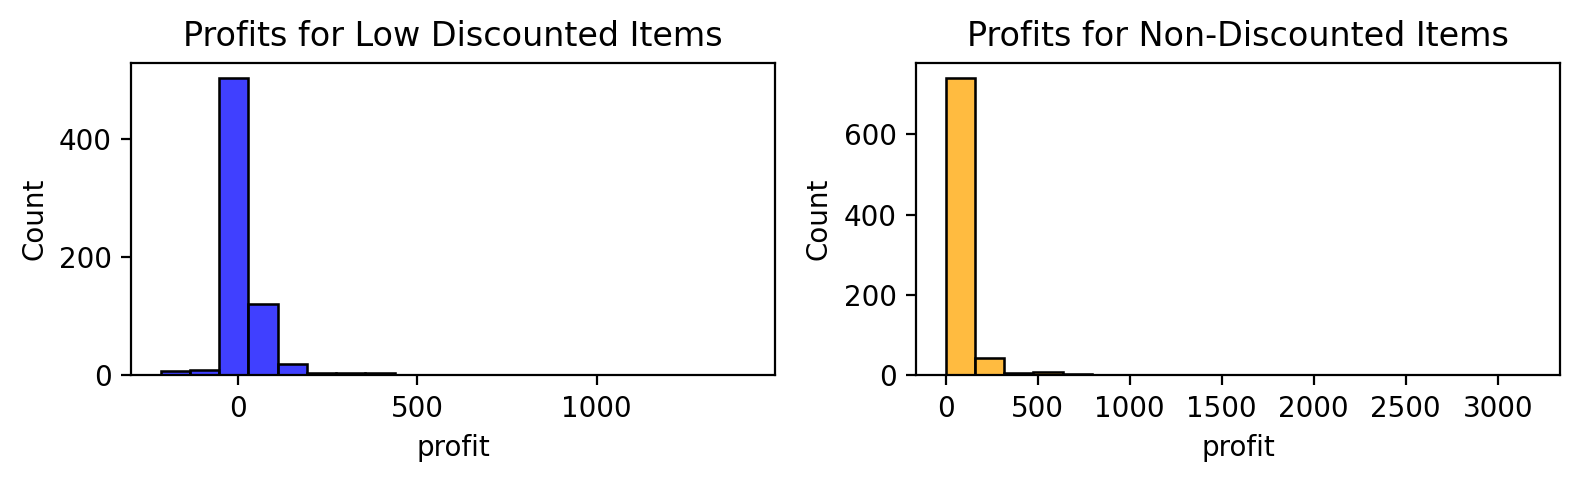

In [98]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,2.5))

sns.histplot(data=low_disc_df, x='profit', bins=20, color='blue', ax=axes[0])
axes[0].set_title('Profits for Low Discounted Items')

sns.histplot(data=non_disc_df, x='profit', bins=20, color='orange', ax=axes[1])
axes[1].set_title('Profits for Non-Discounted Items')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

- Is there a specific discount percentage that leads to the highest profit margins?

What are the counts and frequencies of our specific discounts?

In [74]:
pd.DataFrame([
    df.groupby('discount').size(),
    round(df.groupby('discount').size() / len(df), 2)
]).T.rename(columns={0: 'counts', 1: 'frequencies'})

,counts,frequencies
discount,,
0.00,810.0,0.47
0.10,14.0,0.01
0.15,8.0,0.00
0.20,656.0,0.38
0.30,31.0,0.02
0.32,4.0,0.00
0.40,41.0,0.02
0.45,5.0,0.00
0.50,18.0,0.01


In [76]:
aggregation_functions = {
    'sales': ['median', 'sum'], 'profit': ['median', 'sum'],
    'cost': ['median', 'sum'], 'margin': ['median'],
    'quantity': ['median', 'sum'], 'price': ['median'] }

df.groupby('discount')[['sales', 'profit', 'cost',
                            'margin', 'quantity', 'price']]\
                          .agg(aggregation_functions).round(2)

sales             profit              cost            margin  \
          median        sum  median       sum  median        sum median   
discount                                                                  
0.00       47.04  168123.22   14.54  51268.77   29.89  116854.45   0.34   
0.10      577.25   12254.17  104.92   2252.48  473.11   10001.69   0.18   
0.15      272.82    3250.78   11.24     40.68  253.14    3210.11   0.04   
0.20       56.78  131508.96    6.45  13761.93   47.09  117747.03   0.16   
0.30      388.43   18198.50  -29.25  -1840.44  430.87   20038.93  -0.09   
0.32      368.87    3212.85  -41.61   -411.96  410.47    3624.81  -0.14   
0.40      284.36   30505.65  -56.76  -5921.78  327.58   36427.43  -0.23   
0.45      383.44    2570.95 -167.32  -1057.65  550.76    3628.60  -0.42   
0.50      393.16   17504.85 -183.16  -9109.62  597.61   26614.47  -0.58   
0.60       15.99    1241.43  -10.42  -1121.06   29.98    2362.49  -0.70   
0.70       16.24    6842.41  -12.48  -5702.82   28.95   12545.23  -0.73   
0.80        8.74    2230.06  -15.91  -4218.00   25.75    6448.06  -1.70   

         quantity         price  
           median   sum  median  
discount                         
0.00          3.0  3059   47.04  
0.10          4.0    61  641.39  
0.15          2.0    30  320.97  
0.20          3.0  2451   70.98  
0.30          3.0   130  554.90  
0.32          2.5    11  542.45  
0.40          3.0   190  473.94  
0.45          3.0    17  697.16  
0.50          3.0    67  786.33  
0.60          3.0    69   39.98  
0.70          3.0   315   54.14  
0.80          3.0   180   43.68

- **10% discount rates generates the most profit, but there are few items sold at this discount rate, and they are expensive items, so there's not enough evidence to conclude that this is the profit-maximizing discount rate.**
- There is only enough data at 20%, so we can't compare it to other discount rates to see which generates the most profit.

See correlations for metrics

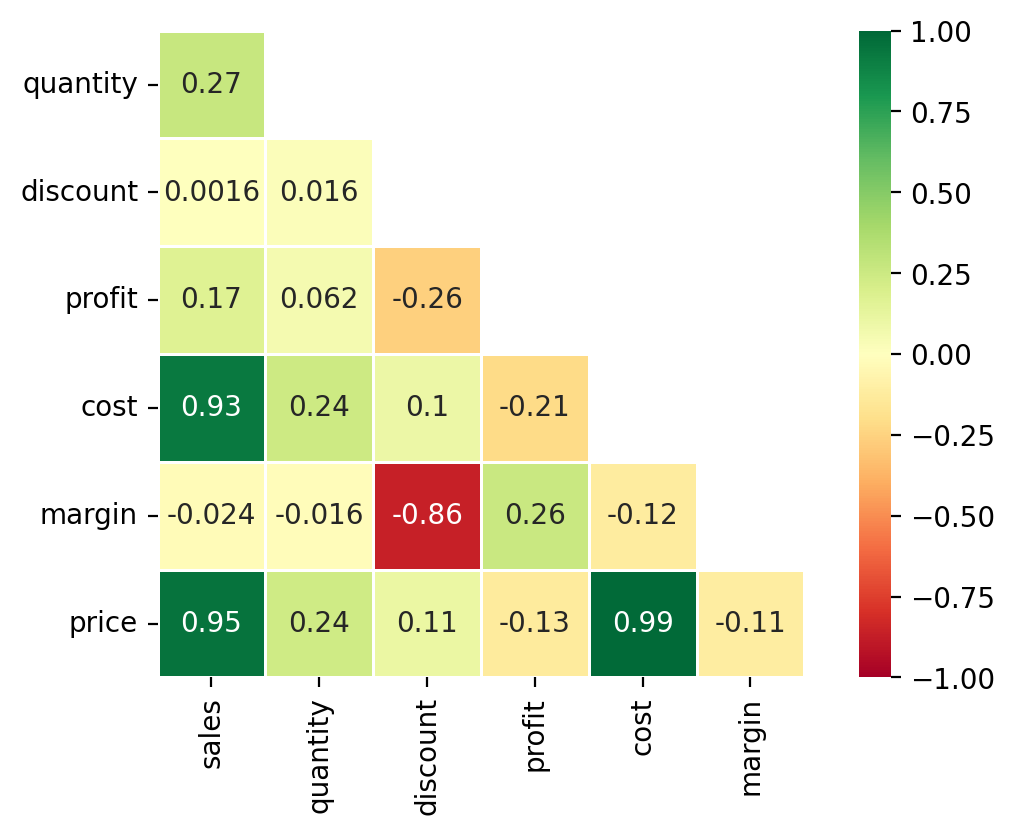

In [9]:
corr_df = df.select_dtypes(include=['number']).iloc[:, [1, 2, 3,
                                                        4, 7, 8, 9]]

plt.figure(figsize=(len(corr_df.columns),
                    len(corr_df.columns) * .6))

mask = np.triu(np.ones_like(corr_df.corr().iloc[1:,:-1]),k=1)
sns.heatmap(corr_df.corr().iloc[1:,:-1], mask=mask, linewidths=.5, annot=True,
                     cmap='RdYlGn', vmin=-1, vmax=1, square=True)
plt.show()

- profit and profit margin have some negative correlation to cost and price, meaning expensive items are not generating as much profit as low-priced items.

**Multivariate Analysis: Discount vs. Profit/Sales/Margin on low, medium, and high-priced items**

First, I want to analyze the sales data to get an idea of how many items are priced in certain price ranges.

How many items sold?

In [10]:
len(df)

1734

How many items priced under \$20?

In [11]:
len(df[df['price'] < 20])

427

In [12]:
len(df[df['price'] < 20]) / len(df)

0.24625144175317185

How many items priced  between \\$20 and \\$100?

In [13]:
len(df[(df['price'] > 20) & (df['price'] < 100)])

577

In [14]:
len(df[(df['price'] > 20) & (df['price'] < 100)]) / len(df)

0.33275663206459055

How many items priced  between \\$100 and \\$300?

In [15]:
len(df[(df['price'] > 100) & (df['price'] < 300)])

336

In [16]:
len(df[(df['price'] > 100) & (df['price'] < 300)]) / len(df)

0.19377162629757785

How many items priced  over \\$300?

In [17]:
len(df[df['price'] > 300])

393

In [18]:
len(df[df['price'] > 300]) / len(df)

0.22664359861591696

What are the 5 lowest priced items?

In [19]:
df['price'].nsmallest(5)

61      1.68
1065    1.81
1224    2.16
1068    2.18
225     2.20
Name: price, dtype: float64

What are the 5 highest priced items?

In [20]:
df['price'].nlargest(5)

683    15999.96
165    13599.92
509     6354.95
27      6166.86
353     5443.96
Name: price, dtype: float64

- cheap items (<\\$20), 25% of sales
- medium-priced items (between \\$20 and \\$100), 33% of sales
- expensive items (between \\$100 and \\$300), 19% of sales
- very-expensive items (>\\$300), 22% of sales

\* A new column `price_bin` will be now be added in `wrangle.py` and based off of these values.

Now to analyze discount rate effects on various priced items.

In [77]:
def analyze_discount_rates(df):
    print('Counts:')
    display(pd.DataFrame([
                df.groupby('discount_bin').size(),
                round(df.groupby('discount_bin').size() / len(df), 2)
            ]).T.rename(columns={0: 'counts', 1: 'frequencies'}))
    
    aggregation_functions = {
    'sales': ['median', 'sum'], 'profit': ['median', 'sum'],
    'margin': ['median'], 'quantity': ['median', 'sum']}

    print('Metrics:')
    display(df.groupby('discount_bin')[['sales', 'profit', 'cost',
                                        'margin', 'quantity']]\
                                      .agg(aggregation_functions).round(2))

In [21]:
cheap_df = df[df['price_bin'] == 'cheap']
med_df = df[df['price_bin'] == 'medium']
exp_df = df[df['price_bin'] == 'expensive']
v_exp_df = df[df['price_bin'] == 'very-expensive']

Cheap items:

In [23]:
analyze_discount_rates(cheap_df)

Counts:


,counts,frequencies
discount_bin,,
0,221.0,0.52
0 - .2,158.0,0.37
>.2,48.0,0.11


Metrics:


sales          profit           cost          margin quantity  \
             median      sum median     sum median      sum median   median   
discount_bin                                                                  
0             10.56  2378.08   4.07  961.44   6.55  1416.64   0.46      2.0   
0 - .2        10.25  1560.09   2.73  415.56   7.03  1144.53   0.32      2.0   
>.2            2.94   153.96  -2.94 -141.77   6.03   295.72  -0.77      2.5   

                   
              sum  
discount_bin       
0             558  
0 - .2        413  
>.2           131

Insights on cheap items:
- How do different discount rates impact sales?
    - **Sales don't increase on discounted orders.**
- Do higher discounts lead to a significant decrease in profitability due to increased costs or reduced margins?
    - **Profit and profit margin decrease significantly on discounted orders.**
- Do customers tend to buy more items when discounts are applied?
    - **Quantity of items sold doesn't seem to increase with discounts.**

**Stats test**: T-test to compare profit, sales, and quantity means for non-discounted and low-discounted (0-20%) items

In [120]:
low_disc_df = cheap_df[cheap_df['discount_bin'] == '0 - .2']
non_disc_df = cheap_df[cheap_df['discount_bin'] == '0']

Plot distributions

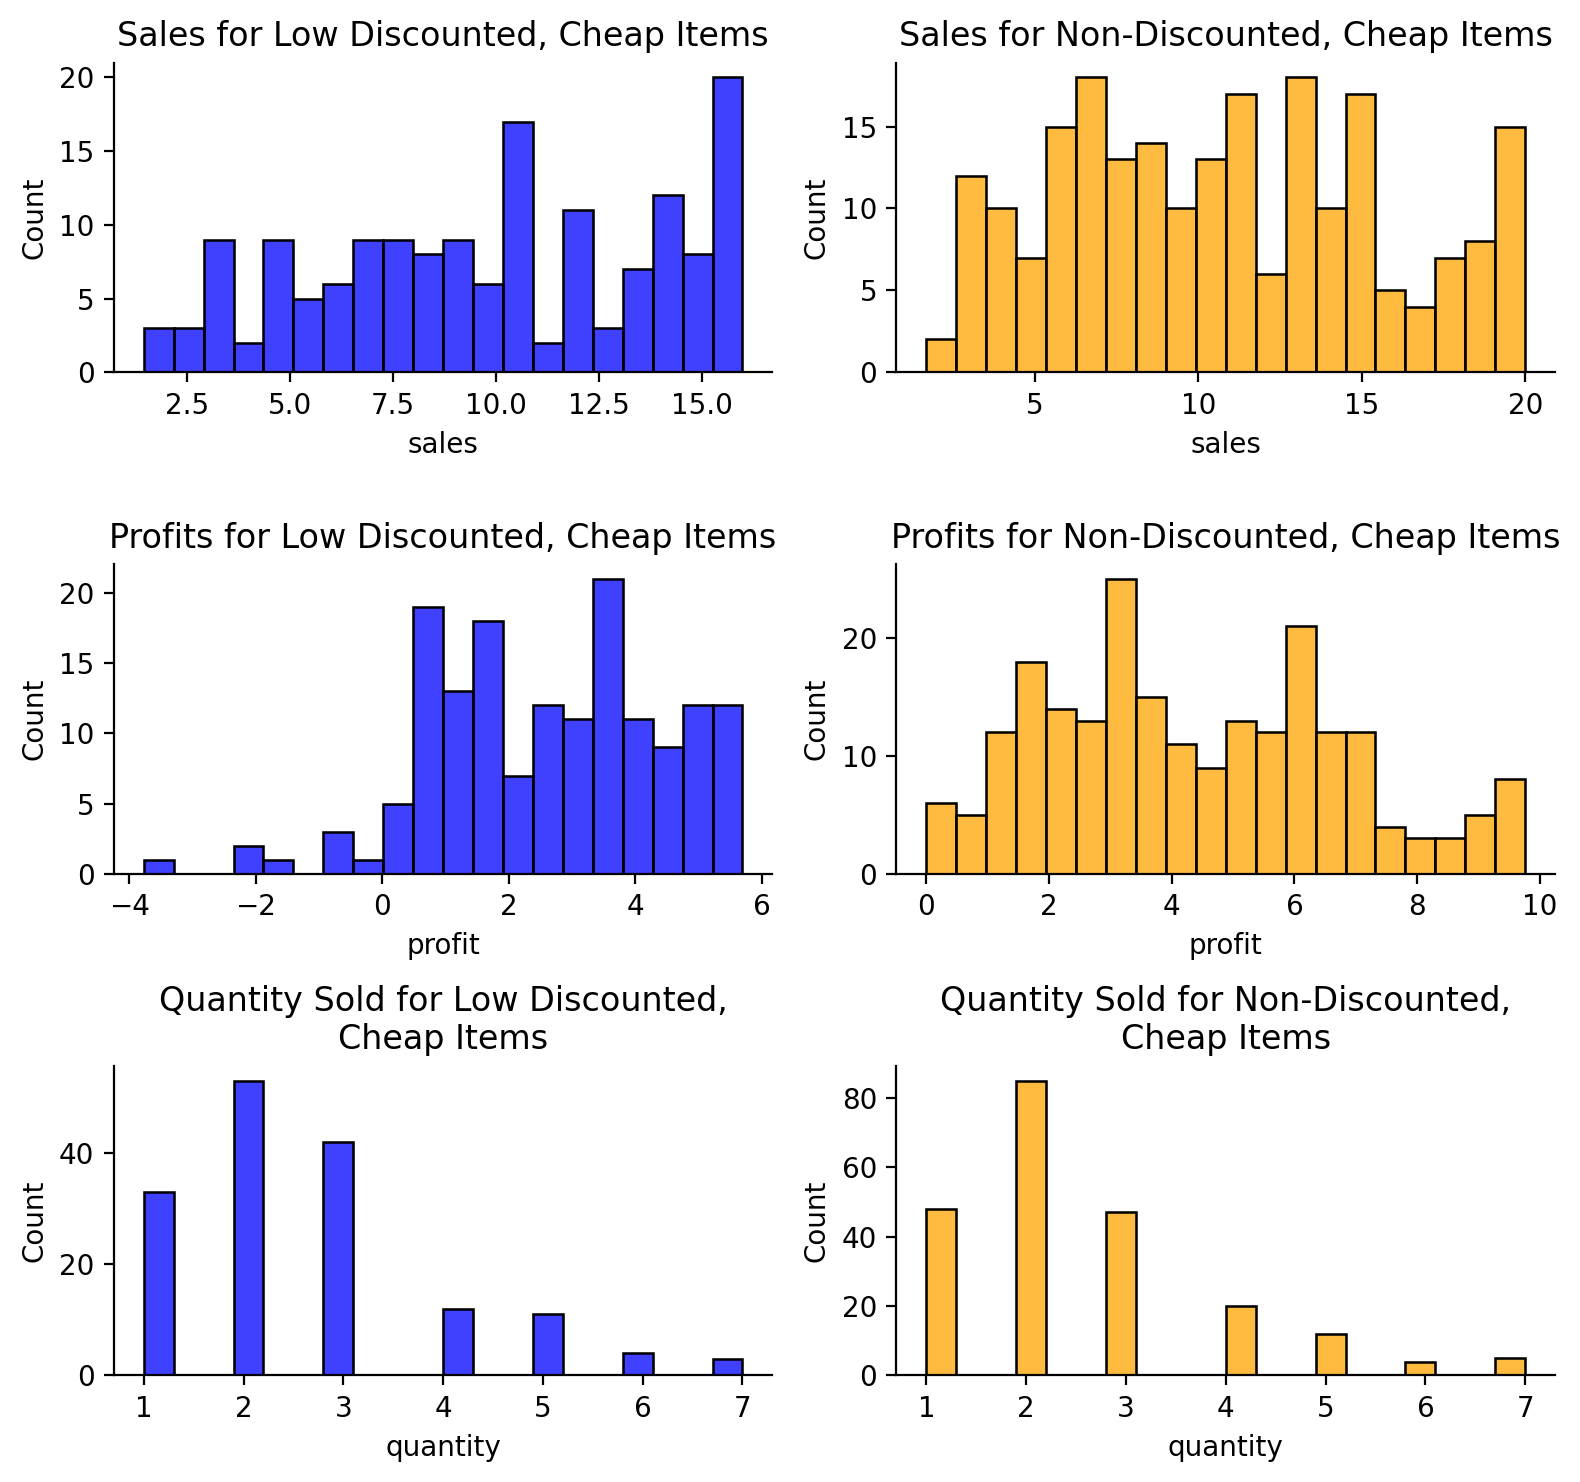

In [125]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8,7.5))

sns.histplot(data=low_disc_df, x='sales', bins=20, color='blue', ax=axes[0,0])
axes[0,0].set_title('Sales for Low Discounted, Cheap Items')

sns.histplot(data=non_disc_df, x='sales', bins=20, color='orange', ax=axes[0,1])
axes[0,1].set_title('Sales for Non-Discounted, Cheap Items')

sns.histplot(data=low_disc_df, x='profit', bins=20, color='blue', ax=axes[1,0])
axes[1,0].set_title('Profits for Low Discounted, Cheap Items')

sns.histplot(data=non_disc_df, x='profit', bins=20, color='orange', ax=axes[1,1])
axes[1,1].set_title('Profits for Non-Discounted, Cheap Items')

sns.histplot(data=low_disc_df, x='quantity', bins=20, color='blue', ax=axes[2,0])
axes[2,0].set_title('Quantity Sold for Low Discounted,\nCheap Items')

sns.histplot(data=non_disc_df, x='quantity', bins=20, color='orange', ax=axes[2,1])
axes[2,1].set_title('Quantity Sold for Non-Discounted,\nCheap Items')

# Adjust layout and display the plots
plt.tight_layout()
sns.despine()
plt.show()

Medium-priced items:

In [101]:
analyze_discount_rates(med_df)

Counts:


,counts,frequencies
discount_bin,,
0,309.0,0.53
0 - .2,206.0,0.36
>.2,63.0,0.11


Metrics:


sales           profit          margin quantity      
             median       sum median      sum median   median   sum
discount_bin                                                       
0             40.99  14861.35  14.35  5068.24   0.39      3.0  1194
0 - .2        31.98   7783.01   6.63  1610.94   0.31      3.0   771
>.2           14.95   1158.97 -12.53  -792.55  -0.73      3.0   223

Insights on medium-priced items:
- How do different discount rates impact sales?
    - **Sales don't increase on discounted orders.**
- Do higher discounts lead to a significant decrease in profitability due to increased costs or reduced margins?
    - **Profit and profit margin decrease significantly on discounted orders.**
- Do customers tend to buy more items when discounts are applied?
    - **Quantity of items sold doesn't seem to increase with discounts.**

**Stats test**: T-test to compare profit, sales, and quantity means for non-discounted and low-discounted (0-20%) items

In [118]:
low_disc_df = med_df[med_df['discount_bin'] == '0 - .2']
non_disc_df = med_df[med_df['discount_bin'] == '0']

Plot distributions

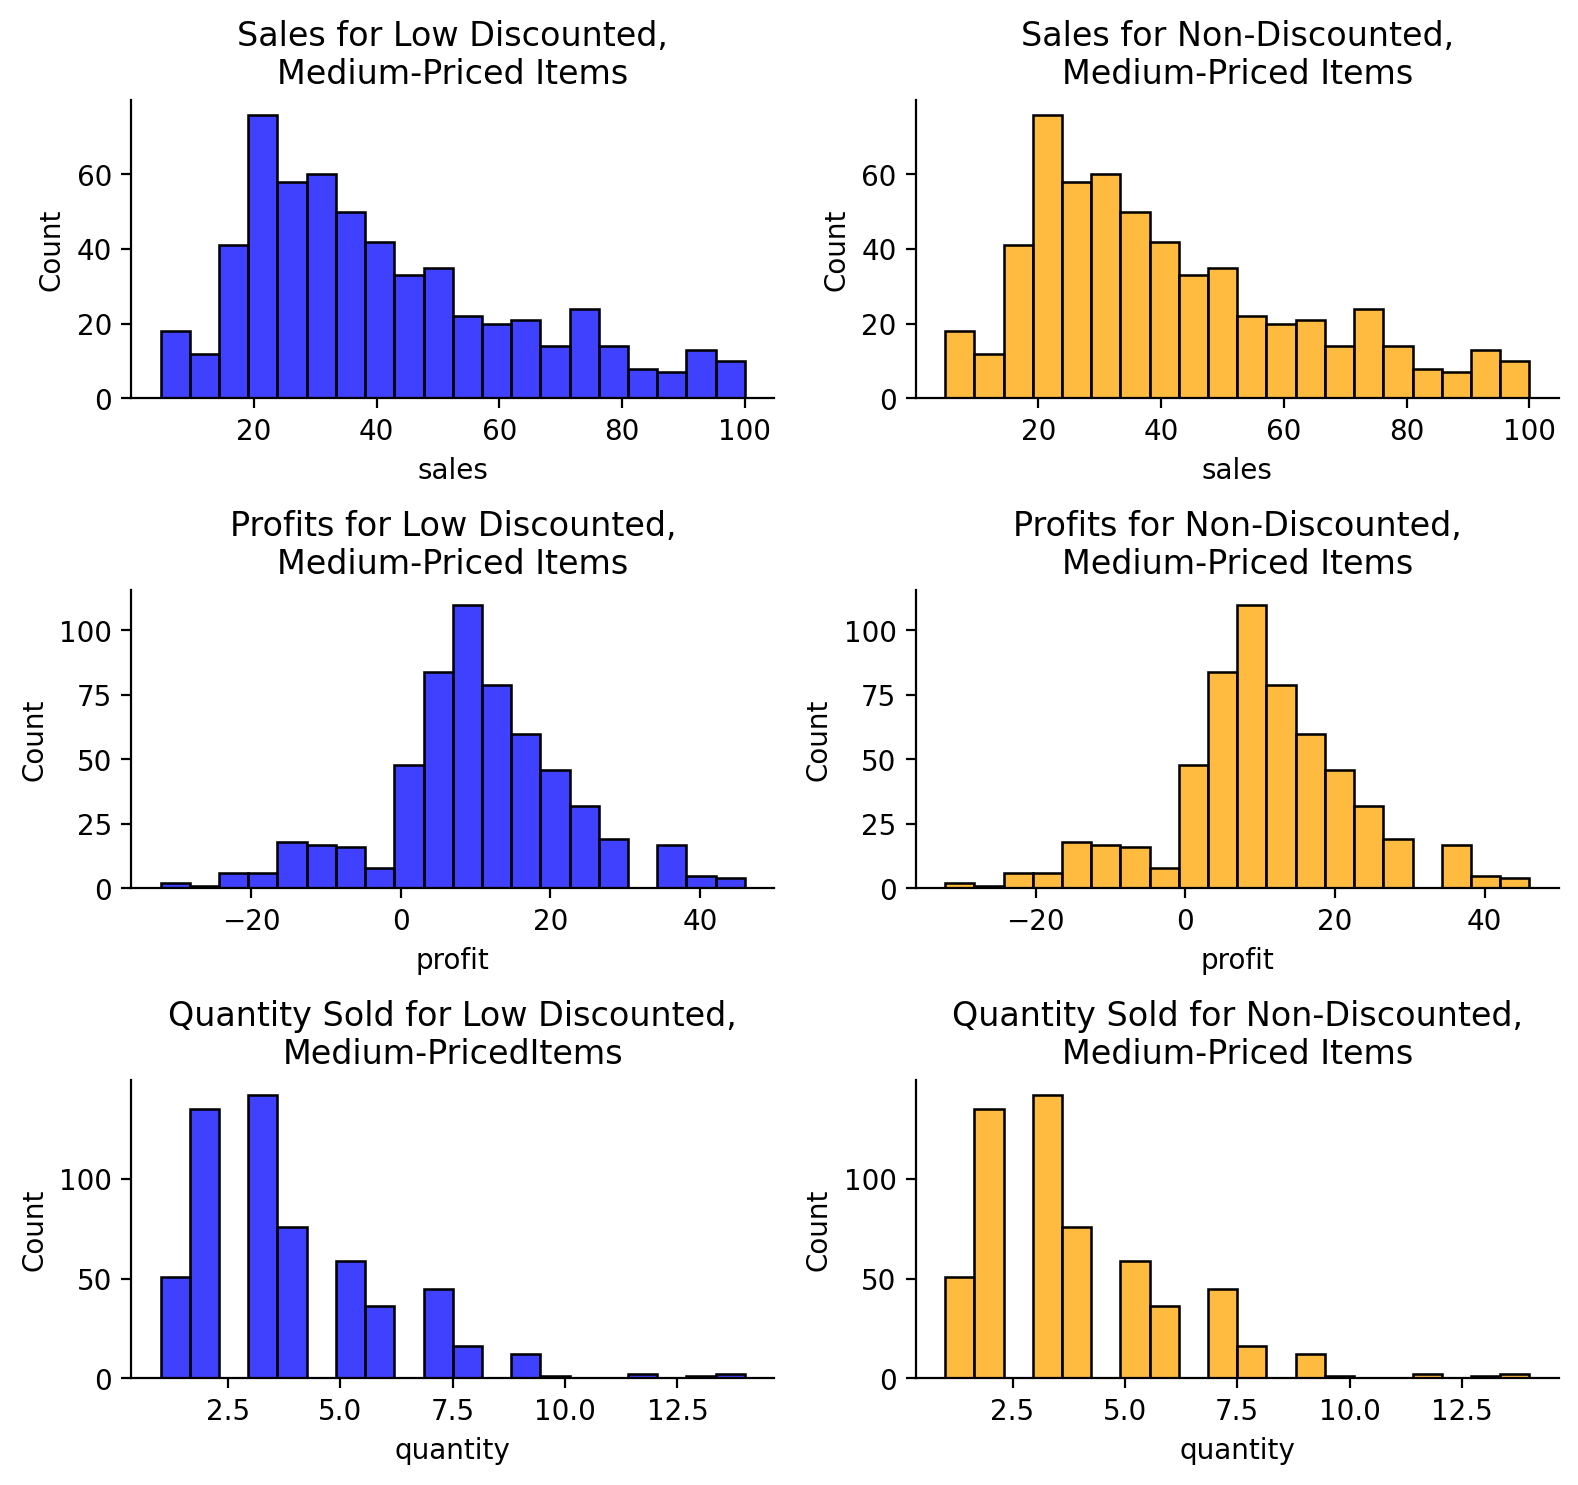

In [128]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8,7.5))

sns.histplot(data=med_df, x='sales', bins=20, color='blue', ax=axes[0,0])
axes[0,0].set_title('Sales for Low Discounted,\nMedium-Priced Items')

sns.histplot(data=med_df, x='sales', bins=20, color='orange', ax=axes[0,1])
axes[0,1].set_title('Sales for Non-Discounted,\nMedium-Priced Items')

sns.histplot(data=med_df, x='profit', bins=20, color='blue', ax=axes[1,0])
axes[1,0].set_title('Profits for Low Discounted,\nMedium-Priced Items')

sns.histplot(data=med_df, x='profit', bins=20, color='orange', ax=axes[1,1])
axes[1,1].set_title('Profits for Non-Discounted,\nMedium-Priced Items')

sns.histplot(data=med_df, x='quantity', bins=20, color='blue', ax=axes[2,0])
axes[2,0].set_title('Quantity Sold for Low Discounted,\nMedium-Priced Items')

sns.histplot(data=med_df, x='quantity', bins=20, color='orange', ax=axes[2,1])
axes[2,1].set_title('Quantity Sold for Non-Discounted,\nMedium-Priced Items')

# Adjust layout and display the plots
plt.tight_layout()
sns.despine()
plt.show()

Expensive items:

In [25]:
analyze_discount_rates(exp_df)

Counts:


,counts,frequencies
discount_bin,,
0,153.0,0.46
0 - .2,139.0,0.41
>.2,44.0,0.13


Metrics:


sales           profit             cost           margin  \
              median       sum median      sum  median       sum median   
discount_bin                                                              
0             167.96  27277.68  51.76  7919.43  121.32  19358.25   0.29   
0 - .2        130.46  19733.78  16.01  2230.82  111.73  17502.97   0.10   
>.2            69.01   3239.22 -32.41 -1861.23  111.46   5100.44  -0.68   

             quantity       
               median  sum  
discount_bin                
0                 3.0  632  
0 - .2            3.0  527  
>.2               3.0  195

Insights on expensive items:
- How do different discount rates impact sales?
    - **Sales actually decrease on discounted orders.**
- Do higher discounts lead to a significant decrease in profitability due to increased costs or reduced margins?
    - **Profit and profit margin decrease significantly on discounted orders.**
- Do customers tend to buy more items when discounts are applied?
    - **Quantity of items sold doesn't seem to increase with discounts.**

**Stats test**: T-test to compare profit, sales, and quantity means for non-discounted and low-discounted (0-20%) items

In [116]:
low_disc_df = exp_df[exp_df['discount_bin'] == '0 - .2']
non_disc_df = exp_df[exp_df['discount_bin'] == '0']

Plot distributions

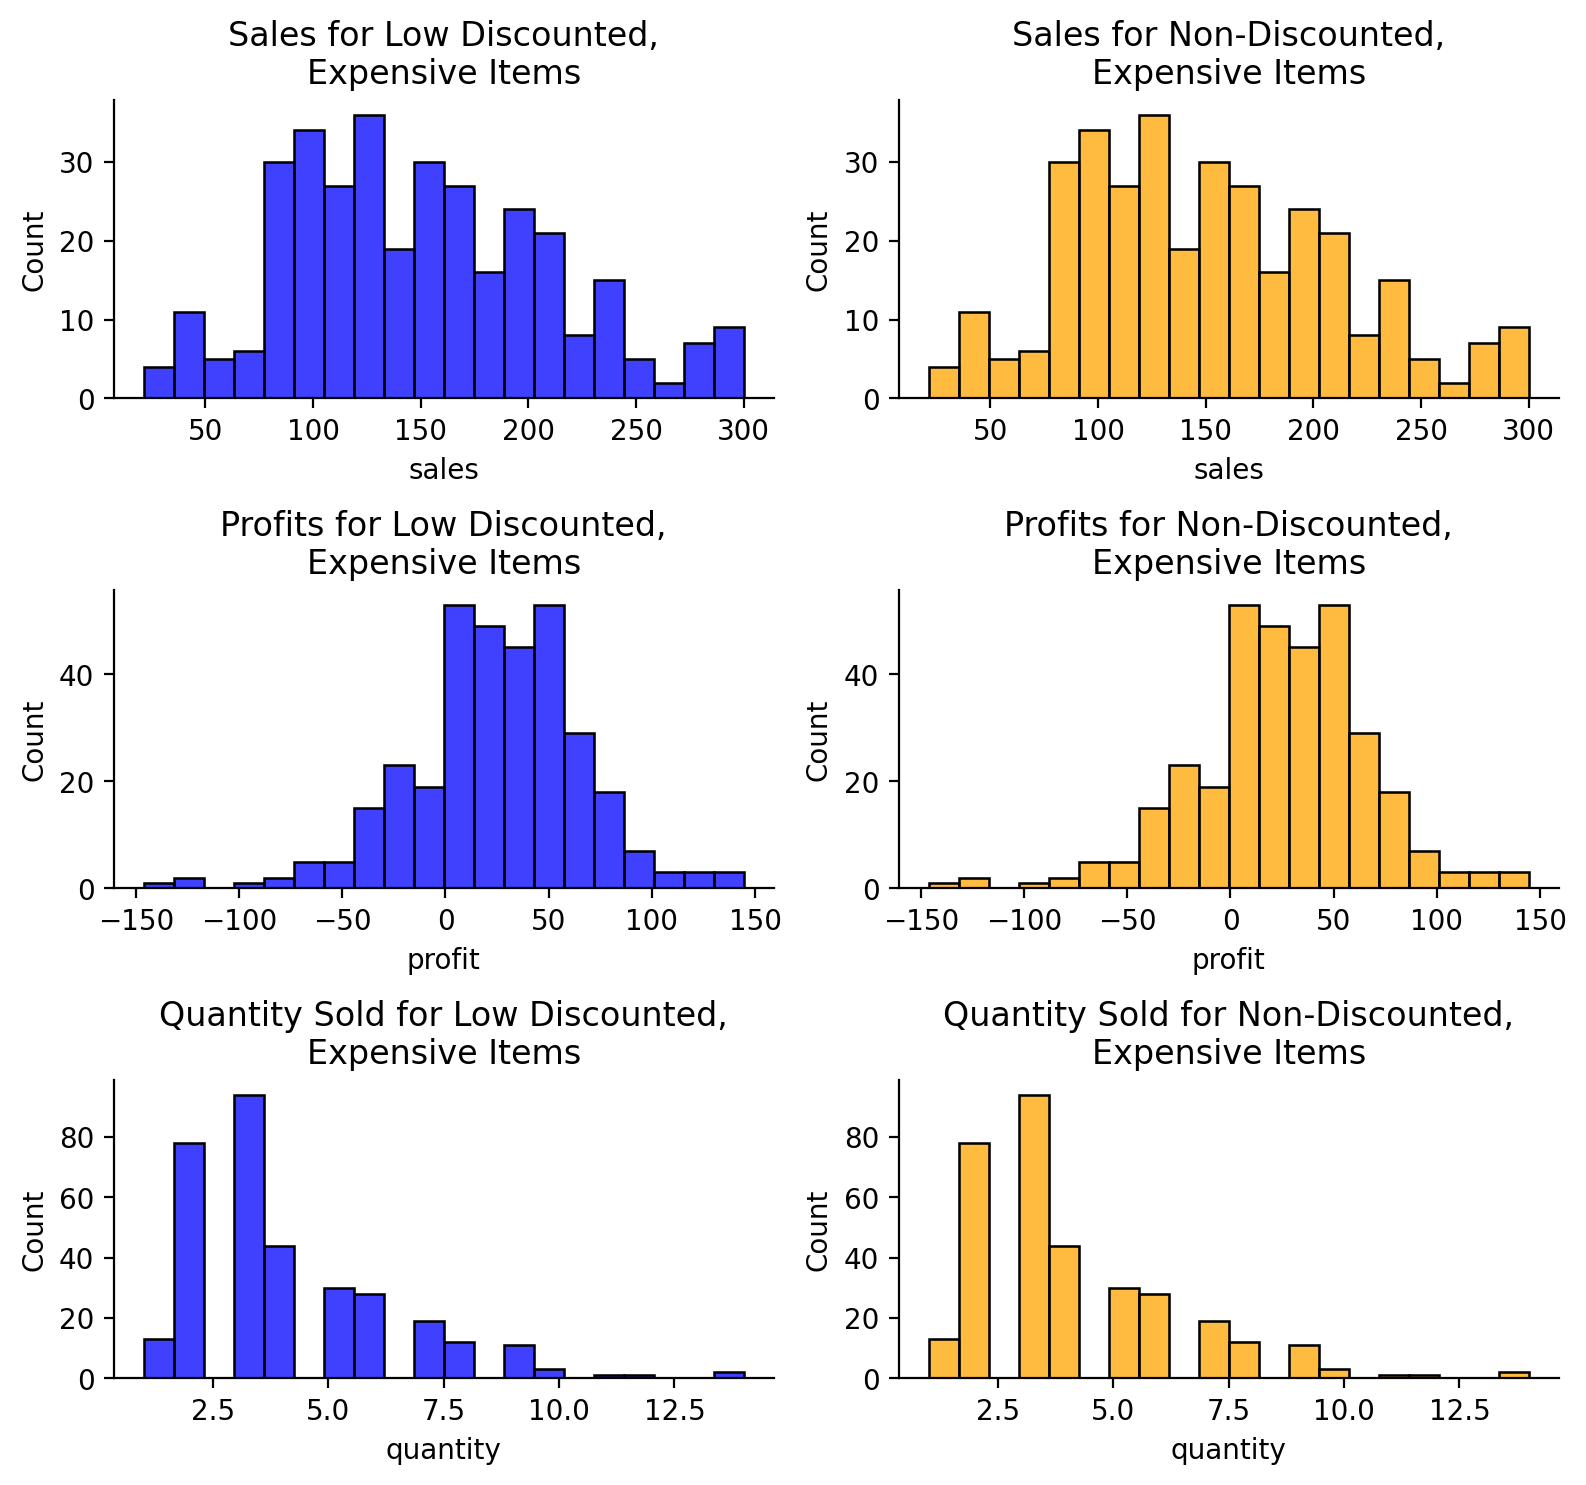

In [129]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8,7.5))

sns.histplot(data=exp_df, x='sales', bins=20, color='blue', ax=axes[0,0])
axes[0,0].set_title('Sales for Low Discounted,\nExpensive Items')

sns.histplot(data=exp_df, x='sales', bins=20, color='orange', ax=axes[0,1])
axes[0,1].set_title('Sales for Non-Discounted,\nExpensive Items')

sns.histplot(data=exp_df, x='profit', bins=20, color='blue', ax=axes[1,0])
axes[1,0].set_title('Profits for Low Discounted,\nExpensive Items')

sns.histplot(data=exp_df, x='profit', bins=20, color='orange', ax=axes[1,1])
axes[1,1].set_title('Profits for Non-Discounted,\nExpensive Items')

sns.histplot(data=exp_df, x='quantity', bins=20, color='blue', ax=axes[2,0])
axes[2,0].set_title('Quantity Sold for Low Discounted,\nExpensive Items')

sns.histplot(data=exp_df, x='quantity', bins=20, color='orange', ax=axes[2,1])
axes[2,1].set_title('Quantity Sold for Non-Discounted,\nExpensive Items')

# Adjust layout and display the plots
plt.tight_layout()
sns.despine()
plt.show()

Very expensive items:

In [26]:
analyze_discount_rates(v_exp_df)

Counts:


,counts,frequencies
discount_bin,,
0,127.0,0.32
0 - .2,175.0,0.45
>.2,91.0,0.23


Metrics:


sales             profit              cost            margin  \
              median        sum  median       sum  median        sum median   
discount_bin                                                                  
0             646.74  123606.11  166.10  37319.67  507.15   86286.44   0.26   
0 - .2        466.77  117937.03   43.84  11797.78  417.46  106139.25   0.09   
>.2           479.99   77754.55 -153.35 -26587.77  696.77  104342.33  -0.30   

             quantity       
               median  sum  
discount_bin                
0                 5.0  675  
0 - .2            4.0  831  
>.2               4.0  430

Insights on very expensive items:
- How do different discount rates impact sales?
    - **Sales actually decrease on discounted orders.**
- Do higher discounts lead to a significant decrease in profitability due to increased costs or reduced margins?
    - **Profit and profit margin decrease significantly on discounted orders.**
- Do customers tend to buy more items when discounts are applied?
    - **Quantity of items sold doesn't increase with discounts.**


STATS TEST
T-test to compare profit, sales, and quantity means for non-discounted and low-discounted (0-20%) items


**Stats test**: T-test to compare profit, sales, and quantity means for non-discounted and low-discounted (0-20%) items

In [114]:
low_disc_df = v_exp_df[v_exp_df['discount_bin'] == '0 - .2']
non_disc_df = v_exp_df[v_exp_df['discount_bin'] == '0']

Plot distributions

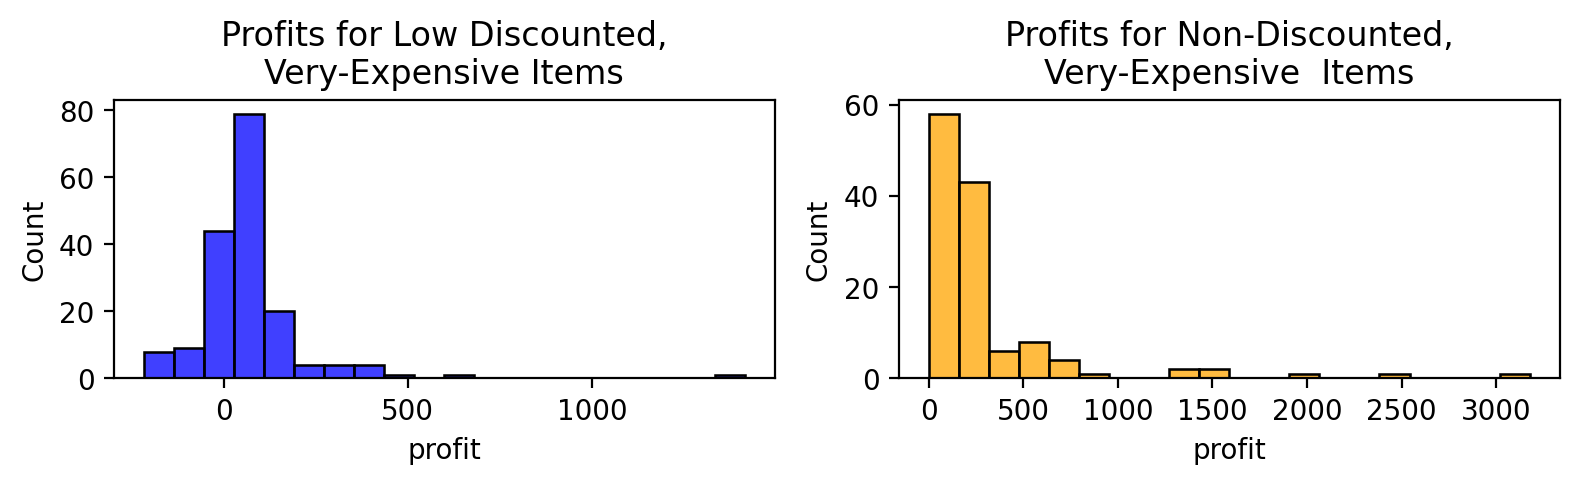

In [115]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,2.5))

sns.histplot(data=low_disc_df, x='profit', bins=20, color='blue', ax=axes[0])
axes[0].set_title('Profits for Low Discounted,\nVery-Expensive Items')

sns.histplot(data=non_disc_df, x='profit', bins=20, color='orange', ax=axes[1])
axes[1].set_title('Profits for Non-Discounted,\nVery-Expensive  Items')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

---
## 4. Customer Impact

Analyze customer response to discounts.

Do returning customers see more discounted orders than non-returning customers?

Create DataFrame where one row represents a unique order

In [47]:
# Grouping by order_id to make orders DataFrame 
orders = df.groupby('order_id').agg({
    'order_date': 'first',  'ship_date': 'first',       'ship_mode': 'first',
    'city': 'first',        'state': 'first',           'postal_code': 'first',
    'sales': 'sum',         'quantity': 'sum',          'discount': 'sum',
    'profit': 'sum',        'customer_name': 'first',   'order_month': 'first',
    'order_year': 'first',  'cost': 'sum',    'margin': 'sum',   'price': 'sum',
})

# Adding a column for returning customers
customer_order_counts = df['customer_name'].value_counts()
orders['returning_customer'] = orders['customer_name'].apply(lambda x: 1\
                                                                       if customer_order_counts[x] > 1
                                                                       else 0)

# Adding a column for orders with discounts
orders['has_discount'] = orders['discount'].apply(lambda x: 1 if x > 0 else 0)

# Resetting the index
orders.reset_index(inplace=True)

orders.head(3)

,order_id,order_date,ship_date,ship_mode,city,state,postal_code,sales,quantity,discount,profit,customer_name,order_month,order_year,cost,margin,price,returning_customer,has_discount
0,CA-2014-101476,2014-09-12,2014-09-13,First Class,New Rochelle,New York,10801,69.990,1,0.0,30.0957,Shirley Daniels,9,2014,39.8943,0.430000,69.99,1,0
1,CA-2014-101602,2014-12-15,2014-12-18,First Class,El Paso,Texas,79907,803.960,8,0.5,-30.9610,Mick Crebagga,12,2014,834.9210,-0.253571,1141.25,1,1
2,CA-2014-103849,2014-05-11,2014-05-16,Standard Class,Fort Worth,Texas,76106,225.016,7,1.0,-70.7293,Paul Gonzalez,5,2014,295.7453,-1.087500,363.91,1,1


What proportion of orders came from returning customers?

In [50]:
orders['returning_customer'].mean().round(2)

0.84

What proportion of orders from returning customers ever saw a discount?
<br>What proportion of orders from non-returning customers ever saw a discount?

In [71]:
print('Proportion of returning-customer orders that are discounted:')
print(orders[orders['returning_customer'] == 1]['has_discount'].mean().round(2))

print('Proportion of non-returning-customer orders that are discounted:')
print(orders[orders['returning_customer'] == 0]['has_discount'].mean().round(2))

Proportion of returning-customer orders that are discounted:
0.62
Proportion of non-returning-customer orders that are discounted:
0.53


We see a 9% difference in our sample data. With a small sample size, however, statistical testing should be done to see if we can conclude that having a discount leads to a customer returning

Are discounts and customer return dependent of each other?
- perform $\chi^2$ test to see if there is a dependent relationship between customer return and discounts.


**Stats test**: $\chi^2$ Test to compare proportions of discounted orders and orders from returning customers.


1. Hypotheses
- Null Hypothesis $H_o$: Customer retention is independent of having a discount
- Alternative Hypothesis $H_\alpha$: Customer retention is dependent of having a discount
- significance level ($\alpha = .05$)


2. Calculate test statistics and p-value. Perform test on contigency table.

In [58]:
observed = pd.crosstab(orders['returning_customer'], orders['has_discount'])
observed

has_discount,0,1
returning_customer,,
0,64,71
1,270,436


In [69]:
chi2, p_val, degf, expected = stats.chi2_contingency(observed)
chi2, p_val, expected

(3.6013962029775275,
 0.05773106644532114,
 array([[ 53.61474435,  81.38525565],
        [280.38525565, 425.61474435]]))

3. Test Conclusion and Results
- Test Statistic (`chi2`): A small chi2 value indicates a small difference between the observed and expected frequencies.
- P-Value (`p_val`): A p value of .058 means there is a 5.8% chance we would observe this data if discounts and customer return were independent (null hypothesis). This probability is not low enough to reject the null hypothesis.
- Expected Values (`expected`): <br>Below are the expected values it the null hypothesis were true: 

|has_discount     | 0 | 1 |
|-----------------|---|---|
|returning_customer|  |  |
|0| 54 | 81|
|1| 280| 425|

The expected values are similar to our observed values

**Test Conclusion** 
<br>Because our p-value is greater than our significance level, $\alpha$, we fail to the null hypothesis. **The evidence isn't significant enough to conclude that having a discount leads to customers returning.**

---
## Exploration Summary

- Insights

- Conclusions

Conclusion
- Discount rates don't appear to drive sales while maintaining profit and profit margins.
- It will be best to analyze these numbers seperately based on item price.